## Problem: 
Payment defaults are detrimental to the business and are a significant cost factor.
Are there any key trends in the data which can help me avoid default-prone customers in the future?

# 0. Import

In [4]:
import numpy             as np
import pandas            as pd
import seaborn           as sns
import matplotlib        as mpl
import plotly.express    as px
import matplotlib.pyplot as plt
import missingno         as msno

%matplotlib inline
plt.style.use('seaborn')

In [5]:
from matplotlib.cbook import boxplot_stats

Settings

In [6]:
plt.rcParams['figure.dpi'] = 100
plt.rcParams["figure.figsize"] = (20,10)

0. Import
1. Checks

EDA:
Create something I can see for their pay amount history

People who pay on different:
Time of day
Weekday 

People who 

Variables to contruct:
number of contracts
number of companies
hours
week date
month 

There might be payment frequency that can predict whether someone will default or not?
payment average over time?

In [7]:
clients  = pd.read_csv("Clients.csv")
payments = pd.read_csv("Payments.csv")

payments["transaction_date"] = pd.to_datetime(payments["transaction_date"],unit='s').dt.date
payments.transaction_date

0        2018-05-22
1        2017-11-26
2        2018-02-22
3        2018-06-24
4        2018-03-22
            ...    
25554    2018-07-19
25555    2018-07-16
25556    2018-07-19
25557    2018-07-22
25558    2018-07-22
Name: transaction_date, Length: 25559, dtype: object

In [8]:
px.histogram(payments.payment_amt,height=800)

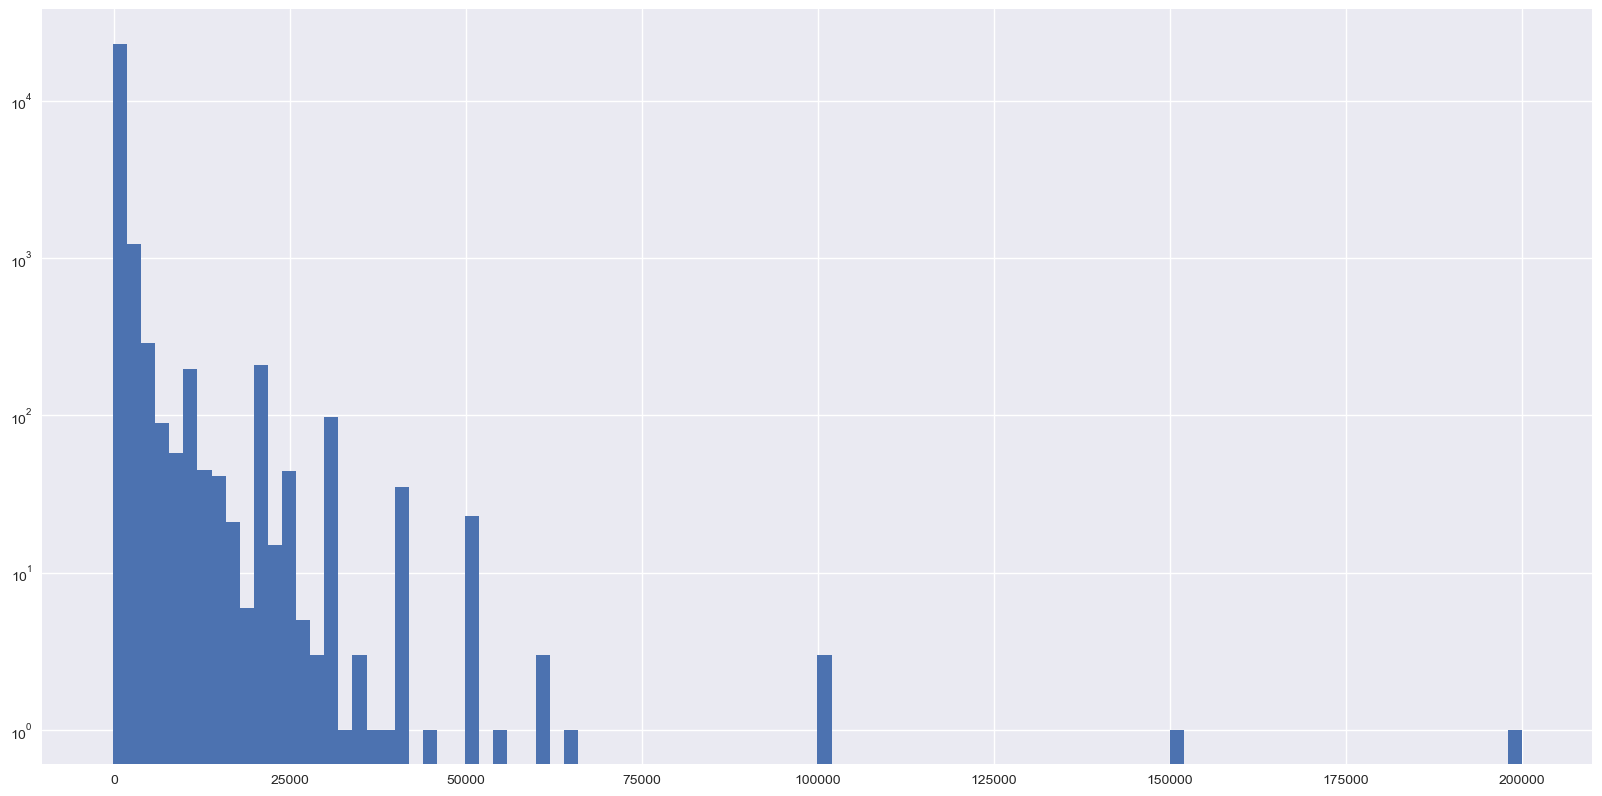

In [9]:
plt.hist(payments.payment_amt, bins=100, log=True)
plt.show()

In [10]:
clients.sort_values(by="client_id").reset_index().drop(columns="index")

client_id                  entity_type  entity_year_established
0             1            Other Partnership                     2006
1             2   Australian Private Company                     2001
2             3   Australian Private Company                     2002
3             4   Australian Private Company                     2007
4             5   Australian Private Company                     2007
...         ...                          ...                      ...
1282       1277       Individual/Sole Trader                     2004
1283       1278             Fixed Unit Trust                     2007
1284       1279  Discretionary Trading Trust                     2017
1285       1280   Australian Private Company                     2016
1286       1281   Australian Private Company                     2012

[1287 rows x 3 columns]

# 1. Checks and Descriptive Statistics

In [11]:
payments.describe()

transaction_id   contract_id     client_id    payment_amt
count    25559.000000  25559.000000  25559.000000   25559.000000
mean     12780.000000    758.221409    602.886811    1221.455691
std       7378.392101    352.190207    344.782295    4346.049363
min          1.000000      1.000000      1.000000    -136.660000
25%       6390.500000    510.000000    308.000000      93.330000
50%      12780.000000    732.000000    593.000000     266.660000
75%      19169.500000    991.000000    894.000000     833.330000
max      25559.000000   1643.000000   1281.000000  200000.050000

In [12]:
clients.describe()

client_id  entity_year_established
count  1287.000000              1287.000000
mean    641.025641              2009.072261
std     369.778060                 5.708598
min       1.000000              1999.000000
25%     321.500000              2004.000000
50%     640.000000              2010.000000
75%     960.500000              2014.000000
max    1281.000000              2018.000000

### 1.1 Missing Values

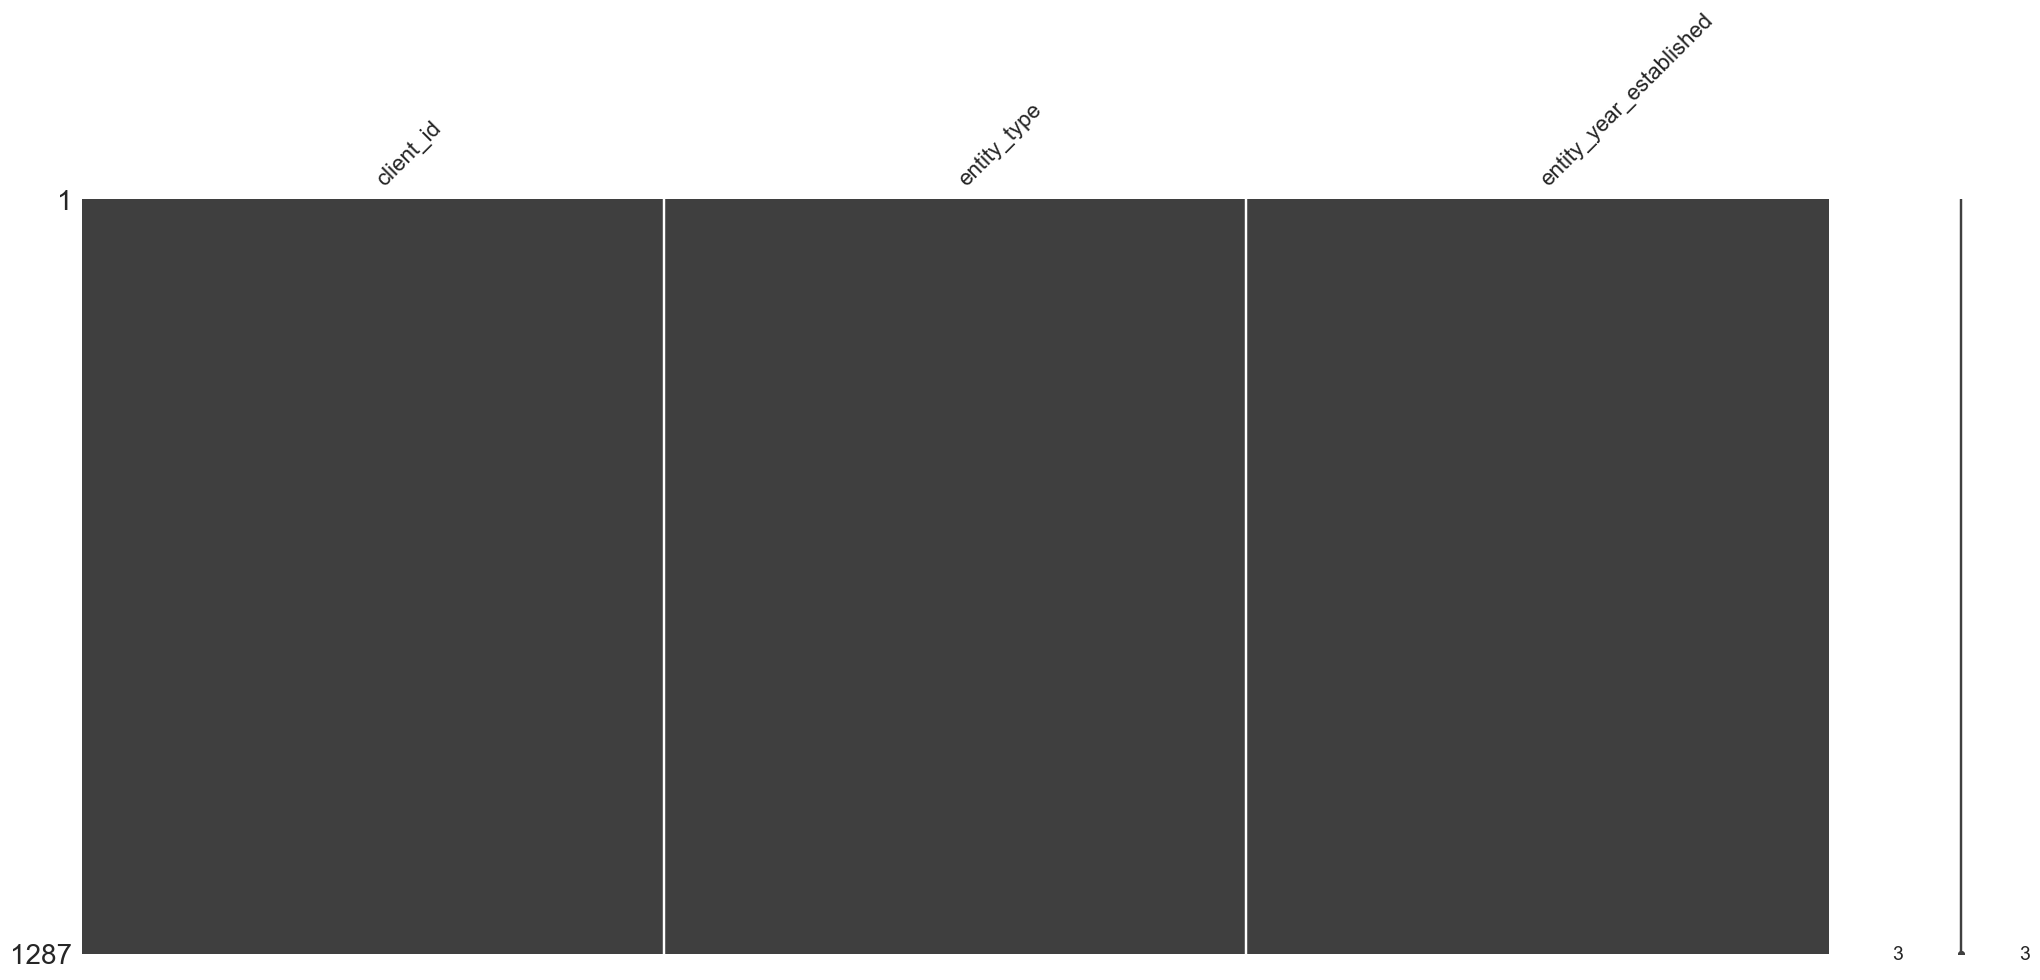

In [185]:
msno.matrix(clients)
plt.show()

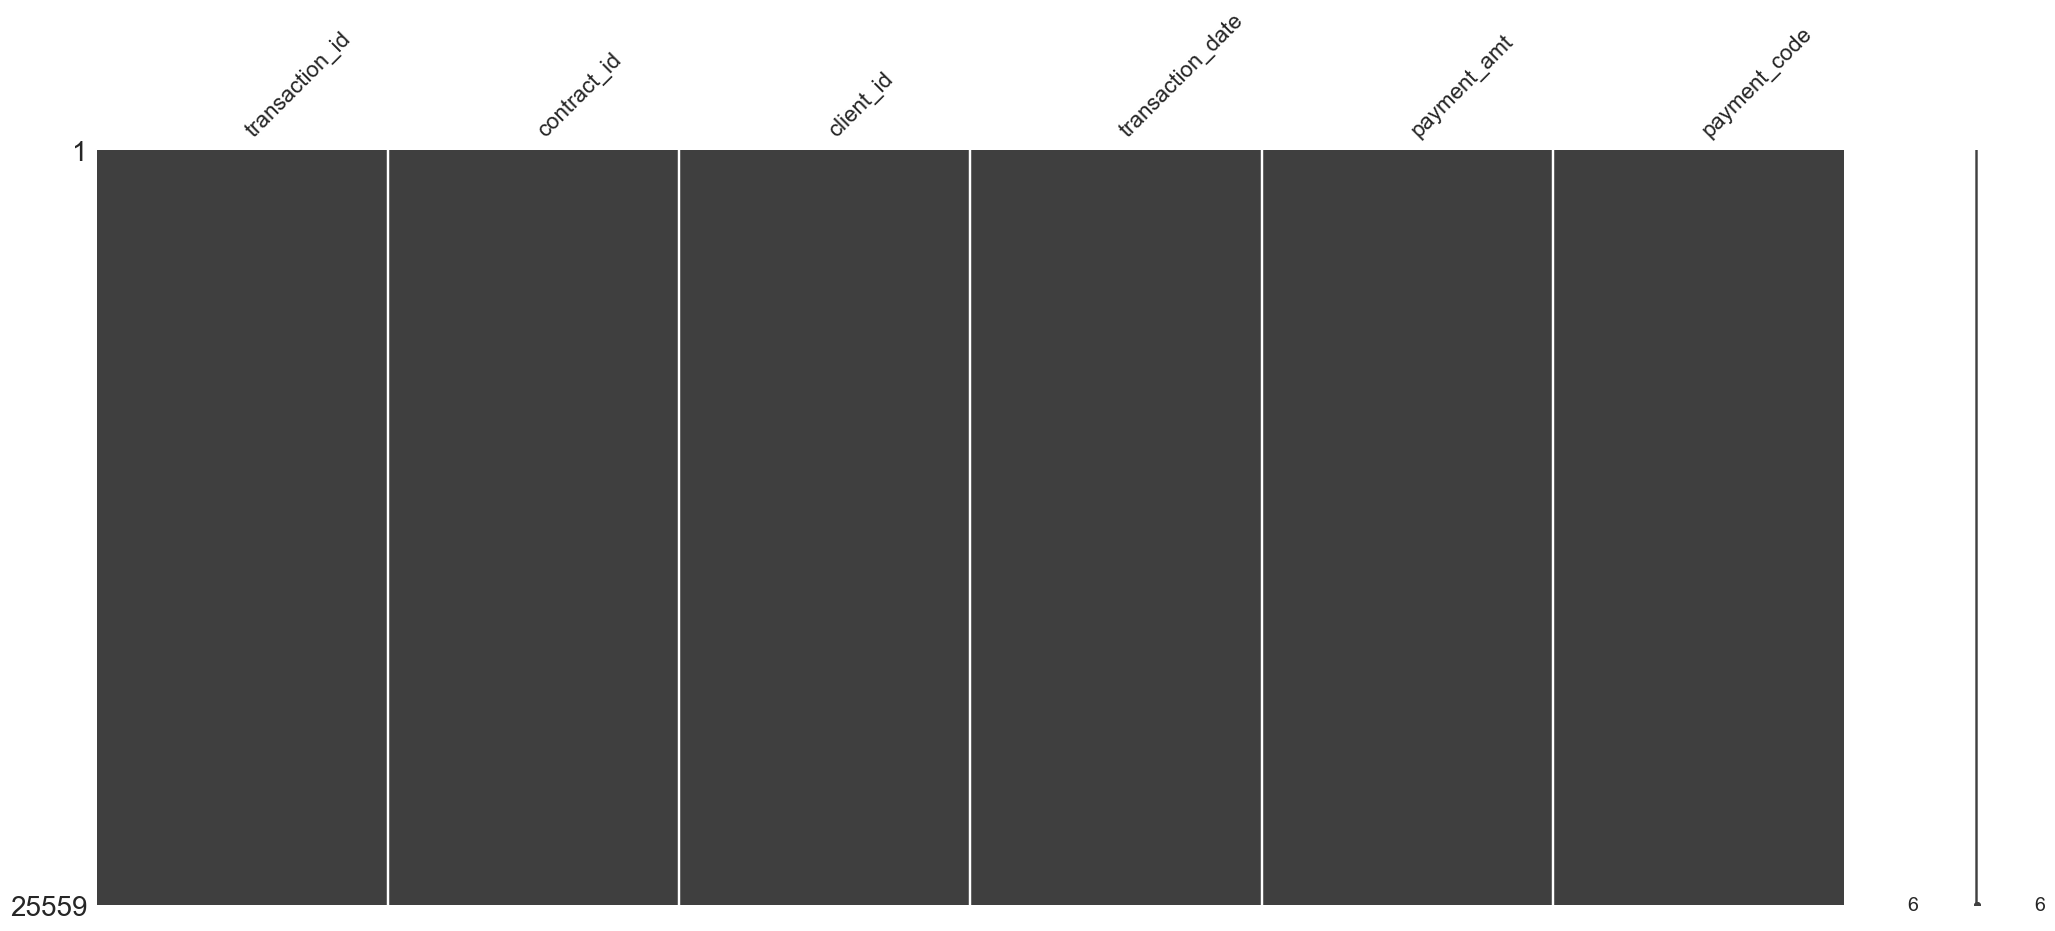

In [186]:
msno.matrix(payments)
plt.show()

### 1.2 Unique Clients

Is the number of unique client_id = n_row of clients data?

In [14]:
print("Number of Clients:", payments.client_id.nunique())
print("Rows of Client Data:", clients.shape[0])

Number of Clients: 1281
Rows of Client Data: 1287


This means there are clients out there that owns more than 1 company

In [15]:
# Groups on client_id and count their occurrences, repeated client_id (> 1) means they own more company
clients_with_companies = clients.groupby("client_id").count().sort_values(by="entity_type", ascending=False)
clients_with_companies_list = clients_with_companies[clients_with_companies.entity_type > 1].index.tolist()

In [16]:
clients[clients.client_id.isin(clients_with_companies_list)].sort_values(by="client_id")

client_id                     entity_type  entity_year_established
401         165      Australian Private Company                     2015
1115        165          Individual/Sole Trader                     2006
332         473      Australian Private Company                     2016
350         473          Individual/Sole Trader                     2008
245         591      Australian Private Company                     2013
306         591      Australian Private Company                     2007
816         591      Australian Private Company                     2015
1063        797  Discretionary Investment Trust                     2016
1275        797      Australian Private Company                     2002
1172       1262      Australian Private Company                     2005
1182       1262      Australian Private Company                     2016

In [17]:
n_types_company = clients.groupby("entity_type").client_id.count().reset_index().rename(columns={"client_id":"total"}).sort_values(by="total")
n_types_company

entity_type  total
1  Australian Proprietary Company      1
7                    Hybrid Trust      1
3  Discretionary Investment Trust      3
6                Fixed Unit Trust      4
2       Australian Public Company      6
9               Other Partnership     10
4     Discretionary Trading Trust     12
5              Family Partnership     39
8          Individual/Sole Trader    457
0      Australian Private Company    754

In [18]:
# sns.barplot(data=company_default_rate, x="entity_type", y="default_pct")
# px.bar(company_default_rate, x="entity_type", y="default_pct",width=1000, height=500)


Problem: It is harder to interpret companies that we don't have much data to such as Hybrid Trust and Discretionary Investment Trust. <br>
Their high default percentage are due to smaller sample size

### 1.3 Negative Values

In [19]:
payments.describe()

transaction_id   contract_id     client_id    payment_amt
count    25559.000000  25559.000000  25559.000000   25559.000000
mean     12780.000000    758.221409    602.886811    1221.455691
std       7378.392101    352.190207    344.782295    4346.049363
min          1.000000      1.000000      1.000000    -136.660000
25%       6390.500000    510.000000    308.000000      93.330000
50%      12780.000000    732.000000    593.000000     266.660000
75%      19169.500000    991.000000    894.000000     833.330000
max      25559.000000   1643.000000   1281.000000  200000.050000

In [20]:
payments[payments.payment_amt < 0]

transaction_id  contract_id  client_id transaction_date  payment_amt  \
5271            16270          564        259       2018-04-03       -55.00   
20089           18574          451        937       2018-05-03      -136.66   

      payment_code  
5271       PAYMENT  
20089      PAYMENT

In [21]:
payments["payment_amt"] = payments["payment_amt"].abs()
payments[payments.payment_amt < 0]

Empty DataFrame
Columns: [transaction_id, contract_id, client_id, transaction_date, payment_amt, payment_code]
Index: []

In [22]:
payments.describe()

transaction_id   contract_id     client_id    payment_amt
count    25559.000000  25559.000000  25559.000000   25559.000000
mean     12780.000000    758.221409    602.886811    1221.470688
std       7378.392101    352.190207    344.782295    4346.045148
min          1.000000      1.000000      1.000000       0.010000
25%       6390.500000    510.000000    308.000000      93.330000
50%      12780.000000    732.000000    593.000000     266.660000
75%      19169.500000    991.000000    894.000000     833.330000
max      25559.000000   1643.000000   1281.000000  200000.050000

### 1.4 Time frame of data set

In [23]:
date_start = payments.transaction_date.min()
date_end   = payments.transaction_date.max()
n_days     = date_end - date_start
print("The dataset spans from: {} to {}. A total of {}" .format(payments.transaction_date.min(), payments.transaction_date.max(), n_days))

The dataset spans from: 2017-07-02 to 2018-07-24. A total of 387 days, 0:00:00


# 2. EDA

## Intro

In [24]:
df = pd.merge(payments, clients, on="client_id")
df["payment_code"] = df["payment_code"].replace({"PAYMENT": True, "DEFAULT": False})
df

transaction_id  contract_id  client_id transaction_date  payment_amt  \
0               20175          927          1       2018-05-22        66.66   
1                8485          927          1       2017-11-26        66.66   
2               13778          927          1       2018-02-22        66.66   
3               22768          927          1       2018-06-24        66.66   
4               15698          927          1       2018-03-22        66.66   
...               ...          ...        ...              ...          ...   
25849           25075         1603       1280       2018-07-19      1666.68   
25850           24711         1603       1280       2018-07-16         0.01   
25851           25076         1603       1280       2018-07-19        64.99   
25852           25132         1627       1281       2018-07-22         0.01   
25853           25131         1627       1281       2018-07-22     20000.05   

       payment_code                 entity_type  entity_year_established  
0              True           Other Partnership                     2006  
1              True           Other Partnership                     2006  
2              True           Other Partnership                     2006  
3              True           Other Partnership                     2006  
4              True           Other Partnership                     2006  
...             ...                         ...                      ...  
25849          True  Australian Private Company                     2016  
25850          True  Australian Private Company                     2016  
25851          True  Australian Private Company                     2016  
25852          True  Australian Private Company                     2012  
25853          True  Australian Private Company                     2012  

[25854 rows x 8 columns]

In [25]:
df.describe()

transaction_id   contract_id     client_id    payment_amt  \
count    25854.000000  25854.000000  25854.000000   25854.000000   
mean     12781.997138    758.568384    602.831477    1225.567675   
std       7383.715669    352.121377    343.589521    4343.662446   
min          1.000000      1.000000      1.000000       0.010000   
25%       6388.250000    510.000000    309.000000      93.330000   
50%      12782.500000    730.000000    591.000000     266.660000   
75%      19181.750000    992.000000    891.000000     833.330000   
max      25559.000000   1643.000000   1281.000000  200000.050000   

       entity_year_established  
count             25854.000000  
mean               2009.150576  
std                   5.616094  
min                1999.000000  
25%                2005.000000  
50%                2011.000000  
75%                2014.000000  
max                2018.000000

##### Company default status Datadframe

In [26]:
default_status = df.groupby(['client_id', 'entity_type', 'entity_year_established'])['payment_code'].all().reset_index().sort_values(by="client_id")
default_status

client_id                  entity_type  entity_year_established  \
0             1            Other Partnership                     2006   
1             2   Australian Private Company                     2001   
2             3   Australian Private Company                     2002   
3             4   Australian Private Company                     2007   
4             5   Australian Private Company                     2007   
...         ...                          ...                      ...   
1282       1277       Individual/Sole Trader                     2004   
1283       1278             Fixed Unit Trust                     2007   
1284       1279  Discretionary Trading Trust                     2017   
1285       1280   Australian Private Company                     2016   
1286       1281   Australian Private Company                     2012   

      payment_code  
0             True  
1             True  
2             True  
3             True  
4             True  
...            ...  
1282          True  
1283          True  
1284          True  
1285          True  
1286          True  

[1287 rows x 4 columns]

In [27]:
default_status_list = default_status[["client_id", "payment_code"]]
default_status_list

client_id  payment_code
0             1          True
1             2          True
2             3          True
3             4          True
4             5          True
...         ...           ...
1282       1277          True
1283       1278          True
1284       1279          True
1285       1280          True
1286       1281          True

[1287 rows x 2 columns]

In [28]:
default_status_list.payment_code.value_counts()

True     919
False    368
Name: payment_code, dtype: int64

In [29]:
entity = df.groupby(["client_id", "entity_type", "entity_year_established", "payment_code", "transaction_date"]).payment_amt.sum().reset_index()
entity["payment_code"] = entity["payment_code"].replace({True: "PAYMENT",False : "DEFAULT"})
default_count = entity.groupby(["client_id", "entity_type", "entity_year_established"]).apply(lambda x: (x['payment_code'] == 'DEFAULT').sum()).reset_index(name='default_count')
default_count

client_id                  entity_type  entity_year_established  \
0             1            Other Partnership                     2006   
1             2   Australian Private Company                     2001   
2             3   Australian Private Company                     2002   
3             4   Australian Private Company                     2007   
4             5   Australian Private Company                     2007   
...         ...                          ...                      ...   
1282       1277       Individual/Sole Trader                     2004   
1283       1278             Fixed Unit Trust                     2007   
1284       1279  Discretionary Trading Trust                     2017   
1285       1280   Australian Private Company                     2016   
1286       1281   Australian Private Company                     2012   

      default_count  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
...             ...  
1282              0  
1283              0  
1284              0  
1285              0  
1286              0  

[1287 rows x 4 columns]

<AxesSubplot:ylabel='payment_code'>

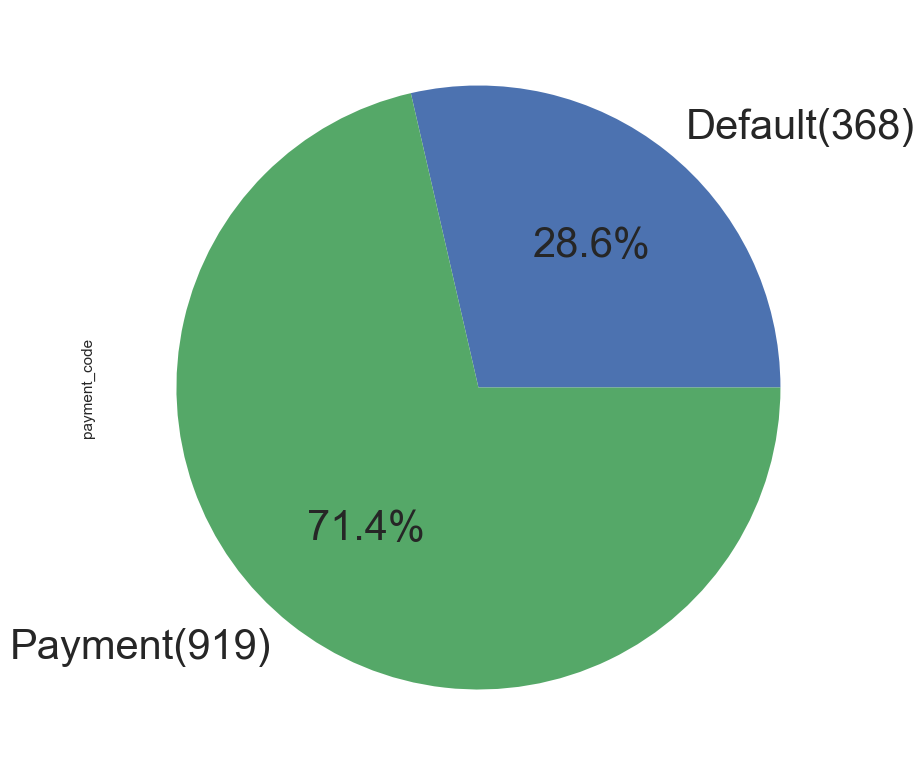

In [30]:
default_status.groupby("payment_code").payment_code.count().plot.pie(y="client_id", autopct='%1.1f%%', textprops={'fontsize': 30}, labels=['Default(368)','Payment(919)'])

28.6% of the Companies has a history of defaulting

## 2.1 Effects of Total Liability of a Client to Default 

##### Code

Creates a dataframe of whether a clients has default before or not:

In [31]:
# TRUE  = Did not default
# FALSE = Has defaulted before
client_default_df = df.groupby(['client_id'])['payment_code'].all().reset_index().sort_values(by="client_id")
client_default_df

client_id  payment_code
0             1          True
1             2          True
2             3          True
3             4          True
4             5          True
...         ...           ...
1276       1277          True
1277       1278          True
1278       1279          True
1279       1280          True
1280       1281          True

[1281 rows x 2 columns]

Calculates the total liability of a client <br>
Whether a company has more than one contracts or more than one contract at a time will be indicated when working with predictive model <br>
For simplicity we take total liability to be the sum of all contract that client owns for one of its company <br>

In [32]:
total_liability = df.groupby(["client_id"]).payment_amt.sum().reset_index()
total_liability

client_id  payment_amt
0             1      9016.68
1             2     25950.03
2             3      4261.68
3             4      8016.56
4             5      5211.69
...         ...          ...
1276       1277     21731.73
1277       1278      9999.98
1278       1279    108658.32
1279       1280     21731.73
1280       1281     20000.06

[1281 rows x 2 columns]

In [33]:
new = df.groupby(['client_id'])['payment_code'].all().reset_index().sort_values(by="client_id")
new

client_id  payment_code
0             1          True
1             2          True
2             3          True
3             4          True
4             5          True
...         ...           ...
1276       1277          True
1277       1278          True
1278       1279          True
1279       1280          True
1280       1281          True

[1281 rows x 2 columns]

In [34]:
total_liability = pd.merge(total_liability, new, on="client_id").sort_values(by="payment_amt")
total_liability

client_id  payment_amt  payment_code
386         387         0.01          True
133         134         0.01          True
812         813        47.34         False
1094       1095        54.70         False
529         530       102.02         False
...         ...          ...           ...
1258       1259    200541.98          True
622         623    200876.24          True
1268       1269    217316.74          True
1194       1195    284276.59         False
590         591    443152.50         False

[1281 rows x 3 columns]

In [35]:
total_liability_payment = total_liability[total_liability.payment_code == True]
total_liability_default = total_liability[total_liability.payment_code == False]


In [36]:
total_liability_payment.describe()
total_liability_default.describe()

client_id    payment_amt
count   365.000000     365.000000
mean    608.383562   27447.992411
std     342.707041   36222.371045
min       7.000000      47.340000
25%     330.000000    7185.750000
50%     610.000000   17250.000000
75%     890.000000   35322.630000
max    1254.000000  443152.500000

In [37]:
def removeOutlier(dataframe, variable):
    """
    Takes in a dataframe and variable/feature of interest
    
    Removes outlier for the distribution of that variable

    Args:
        dataframe (_type_): _description_
        variable  (_type_): _description_

    Returns:
        pandas DataFrame
    """

    outliers  = pd.Series(boxplot_stats(dataframe[variable]).pop(0)['fliers']).to_list()
    dataframe = dataframe.drop(dataframe[dataframe[variable].isin(outliers)].index)
    return dataframe

##### Results

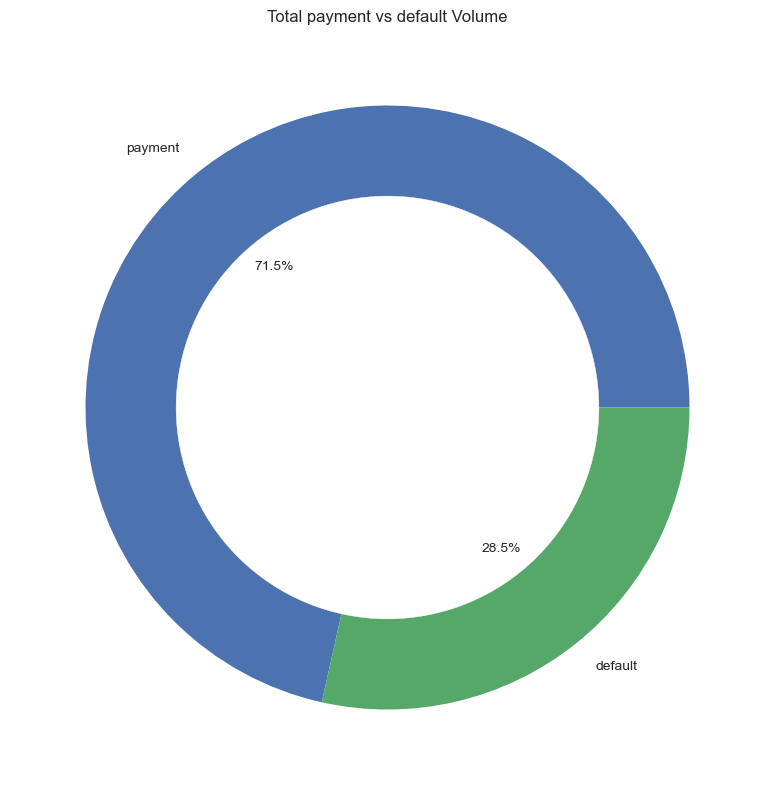

In [38]:
# Visualization of the percentage of spending vs income transaction in the dataset

# Rather than doing .sum() to count the amount transaction of each group, simply accessing the number of rows using shape is sufficient
plt.pie([total_liability_payment.shape[0], total_liability_default.shape[0]], labels=["payment", "default"], autopct='%1.1f%%')

# add a circle at the center to transform it in a donut chart
my_circle=plt.Circle( (0,0), 0.7, color='white')
p=plt.gcf()
p.gca().add_artist(my_circle)

plt.title("Total payment vs default Volume")
plt.show()

28.5% of all of our clients have a history of default

([<matplotlib.axis.XTick at 0x28834be4190>,
 [Text(0, 0, 'Default'), Text(1, 0, 'Payment')])

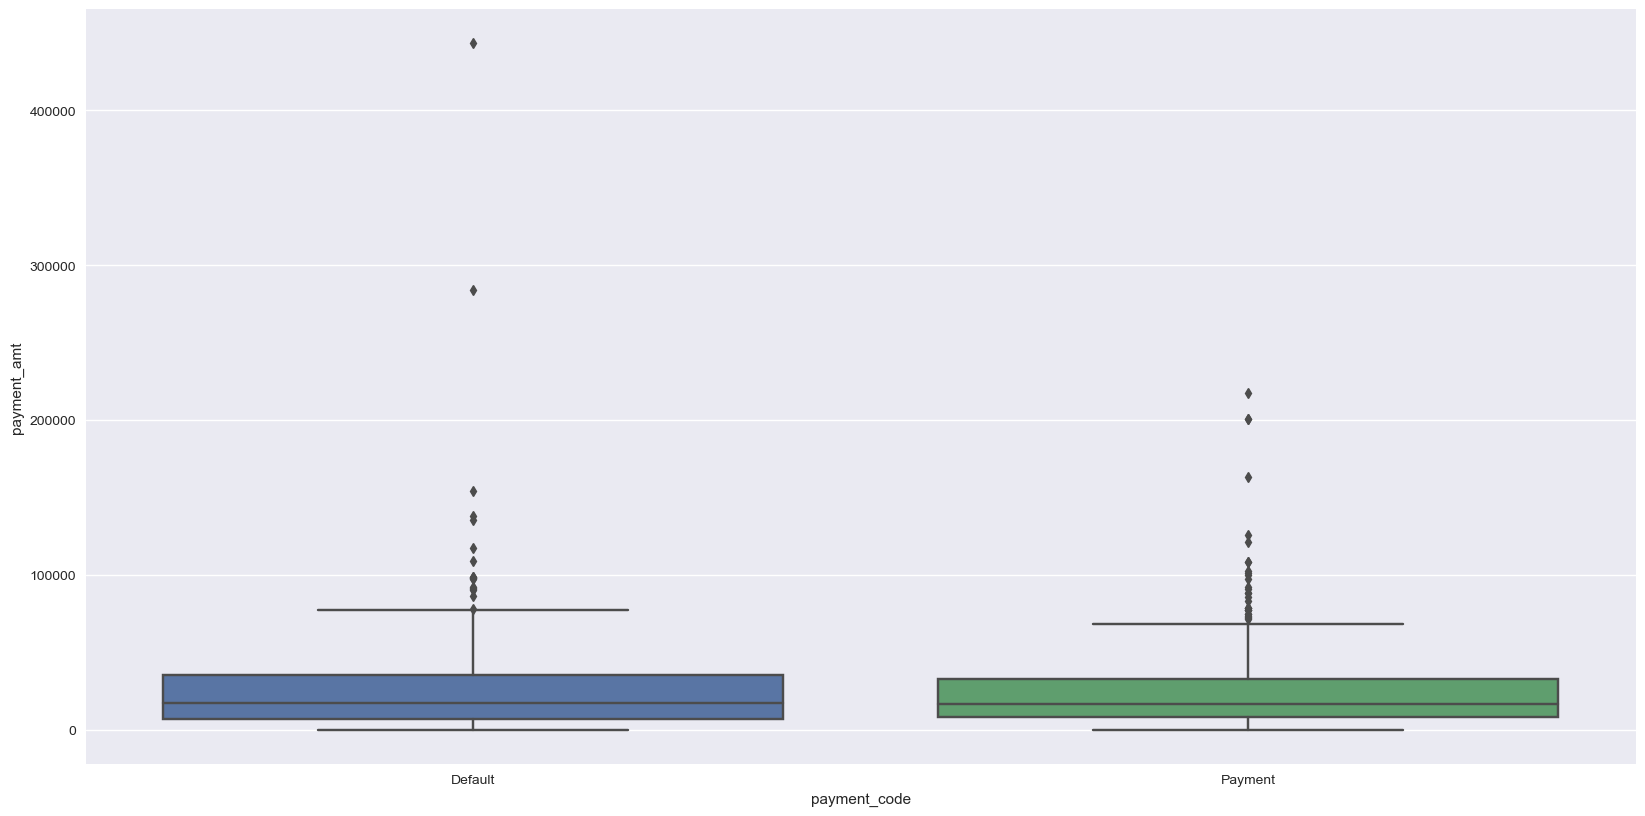

In [39]:
sns.boxplot(x="payment_code", y="payment_amt", data=total_liability)
plt.xticks([0, 1], ["Default", "Payment"])

([<matplotlib.axis.XTick at 0x2883476d7f0>,
 [Text(0, 0, 'Default'), Text(1, 0, 'Payment')])

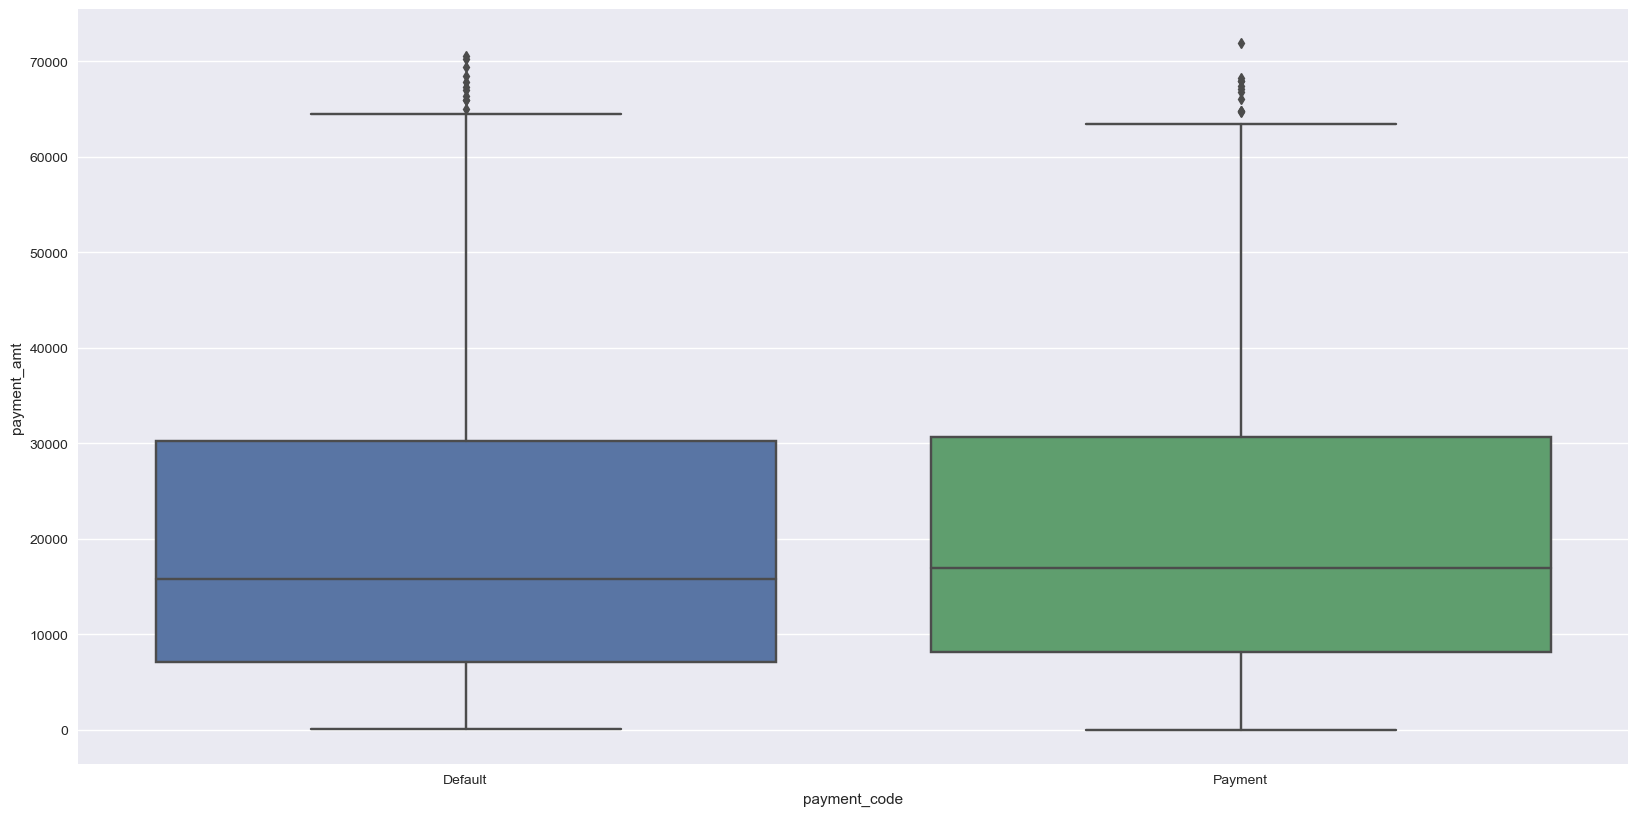

In [40]:
sns.boxplot(x="payment_code", y="payment_amt", data=removeOutlier(total_liability, "payment_amt"))
plt.xticks([0, 1], ["Default", "Payment"])

<AxesSubplot:xlabel='payment_code', ylabel='payment_amt'>

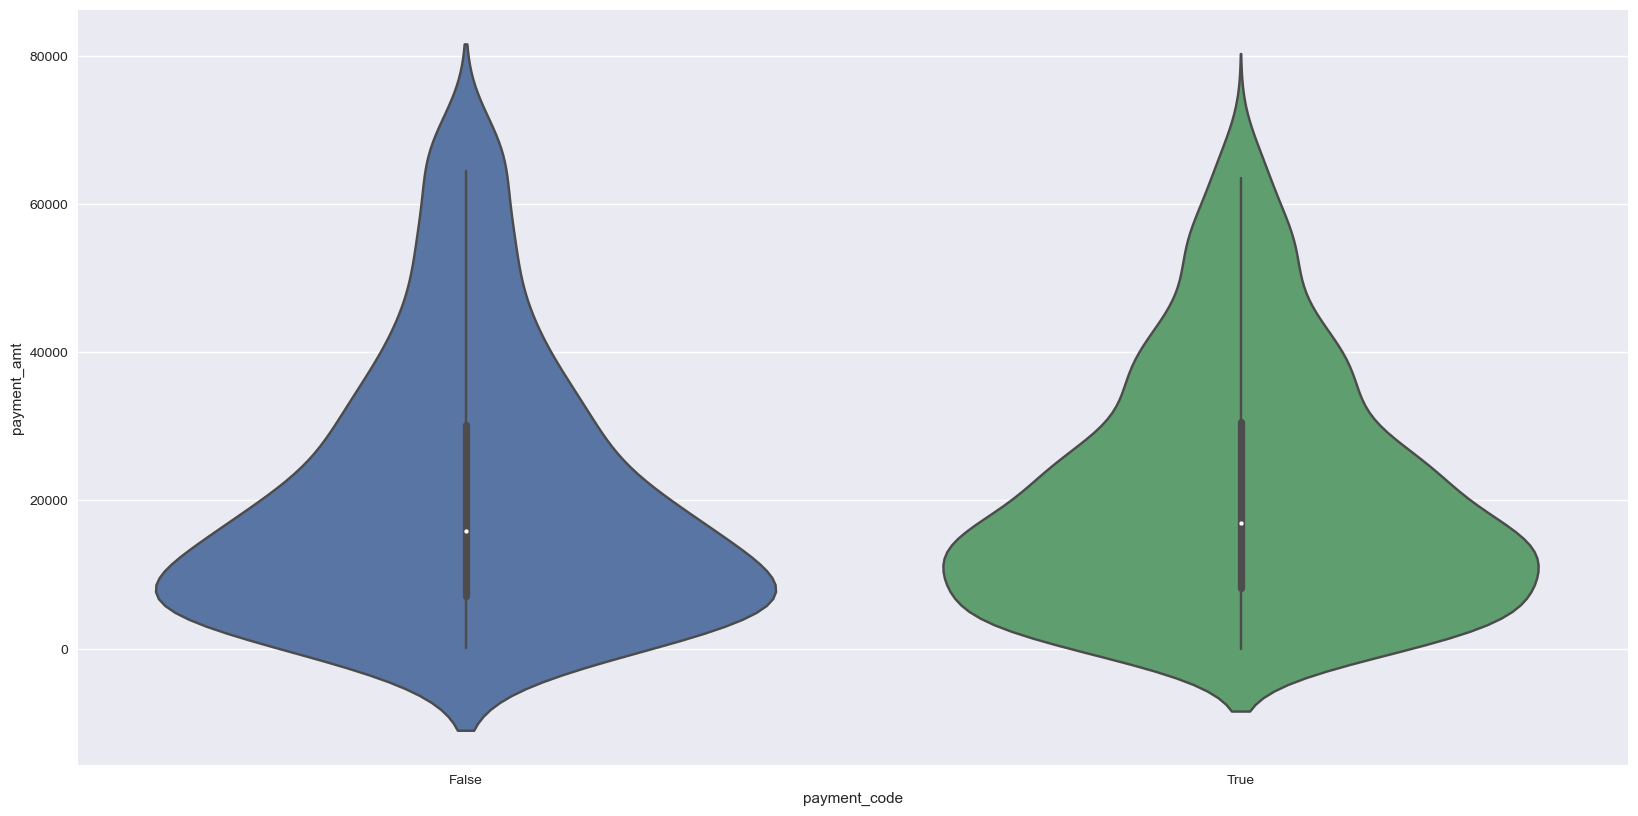

In [41]:
sns.violinplot(x="payment_code", y="payment_amt", data=removeOutlier(total_liability, "payment_amt"))

In [42]:
test = removeOutlier(total_liability, "payment_amt")

In [43]:
from sklearn.preprocessing import StandardScaler
X = test.payment_amt.values
y = test.payment_code

scaler = StandardScaler()
X = scaler.fit_transform(X.reshape(-1,1))

<AxesSubplot:ylabel='payment_code'>

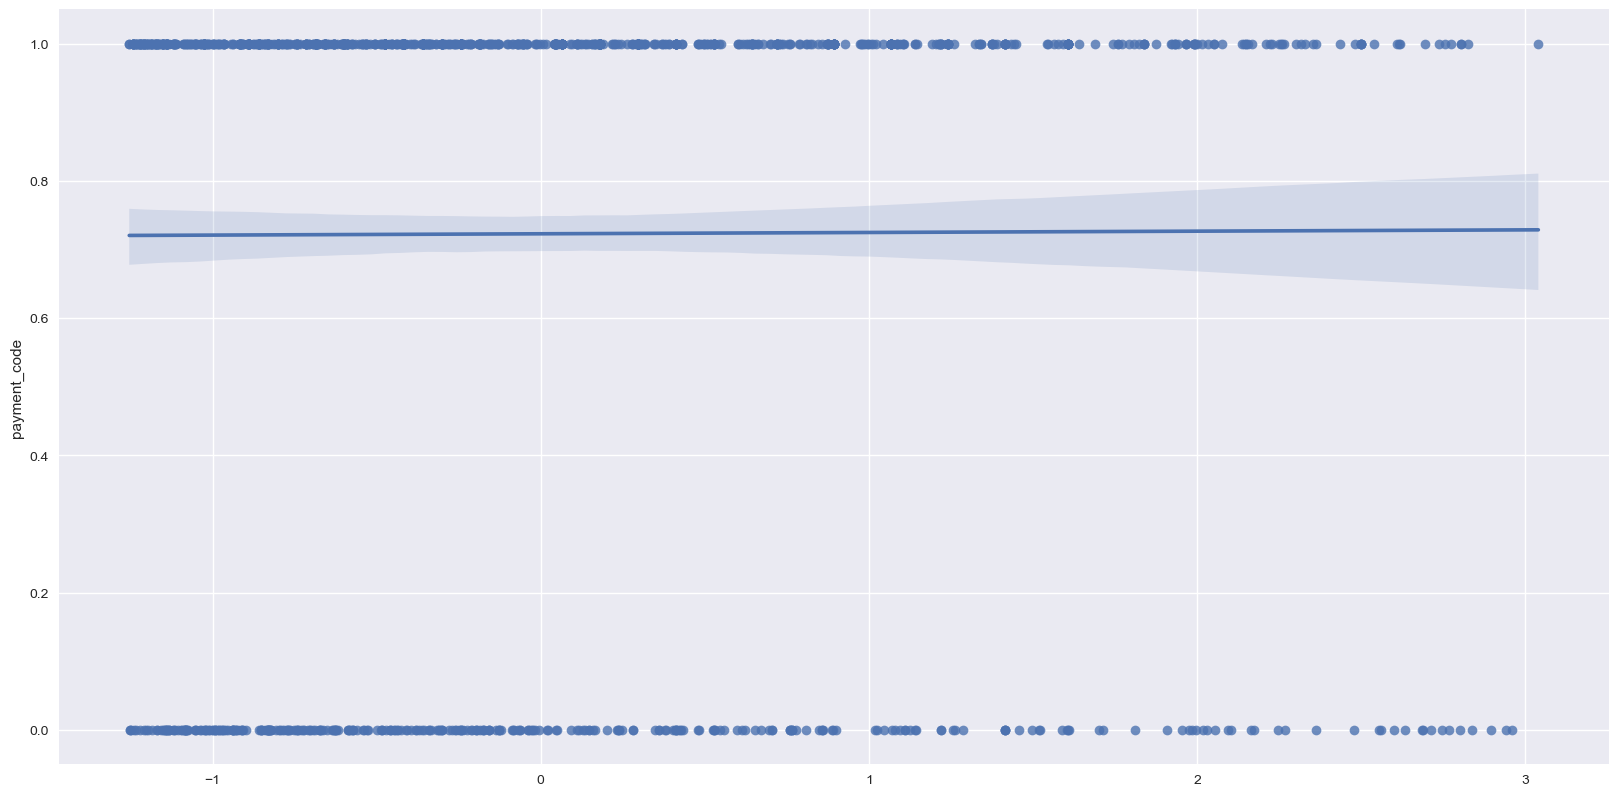

In [44]:
sns.regplot(x=X, y=y, logistic=True)


##### Conclusion

There doesn't seem to be much effect that the total liability of a client has on whether or not they default or not

## 2.2 Default Rate by Entity Type

#### 2.2.1 Entity Default Rate

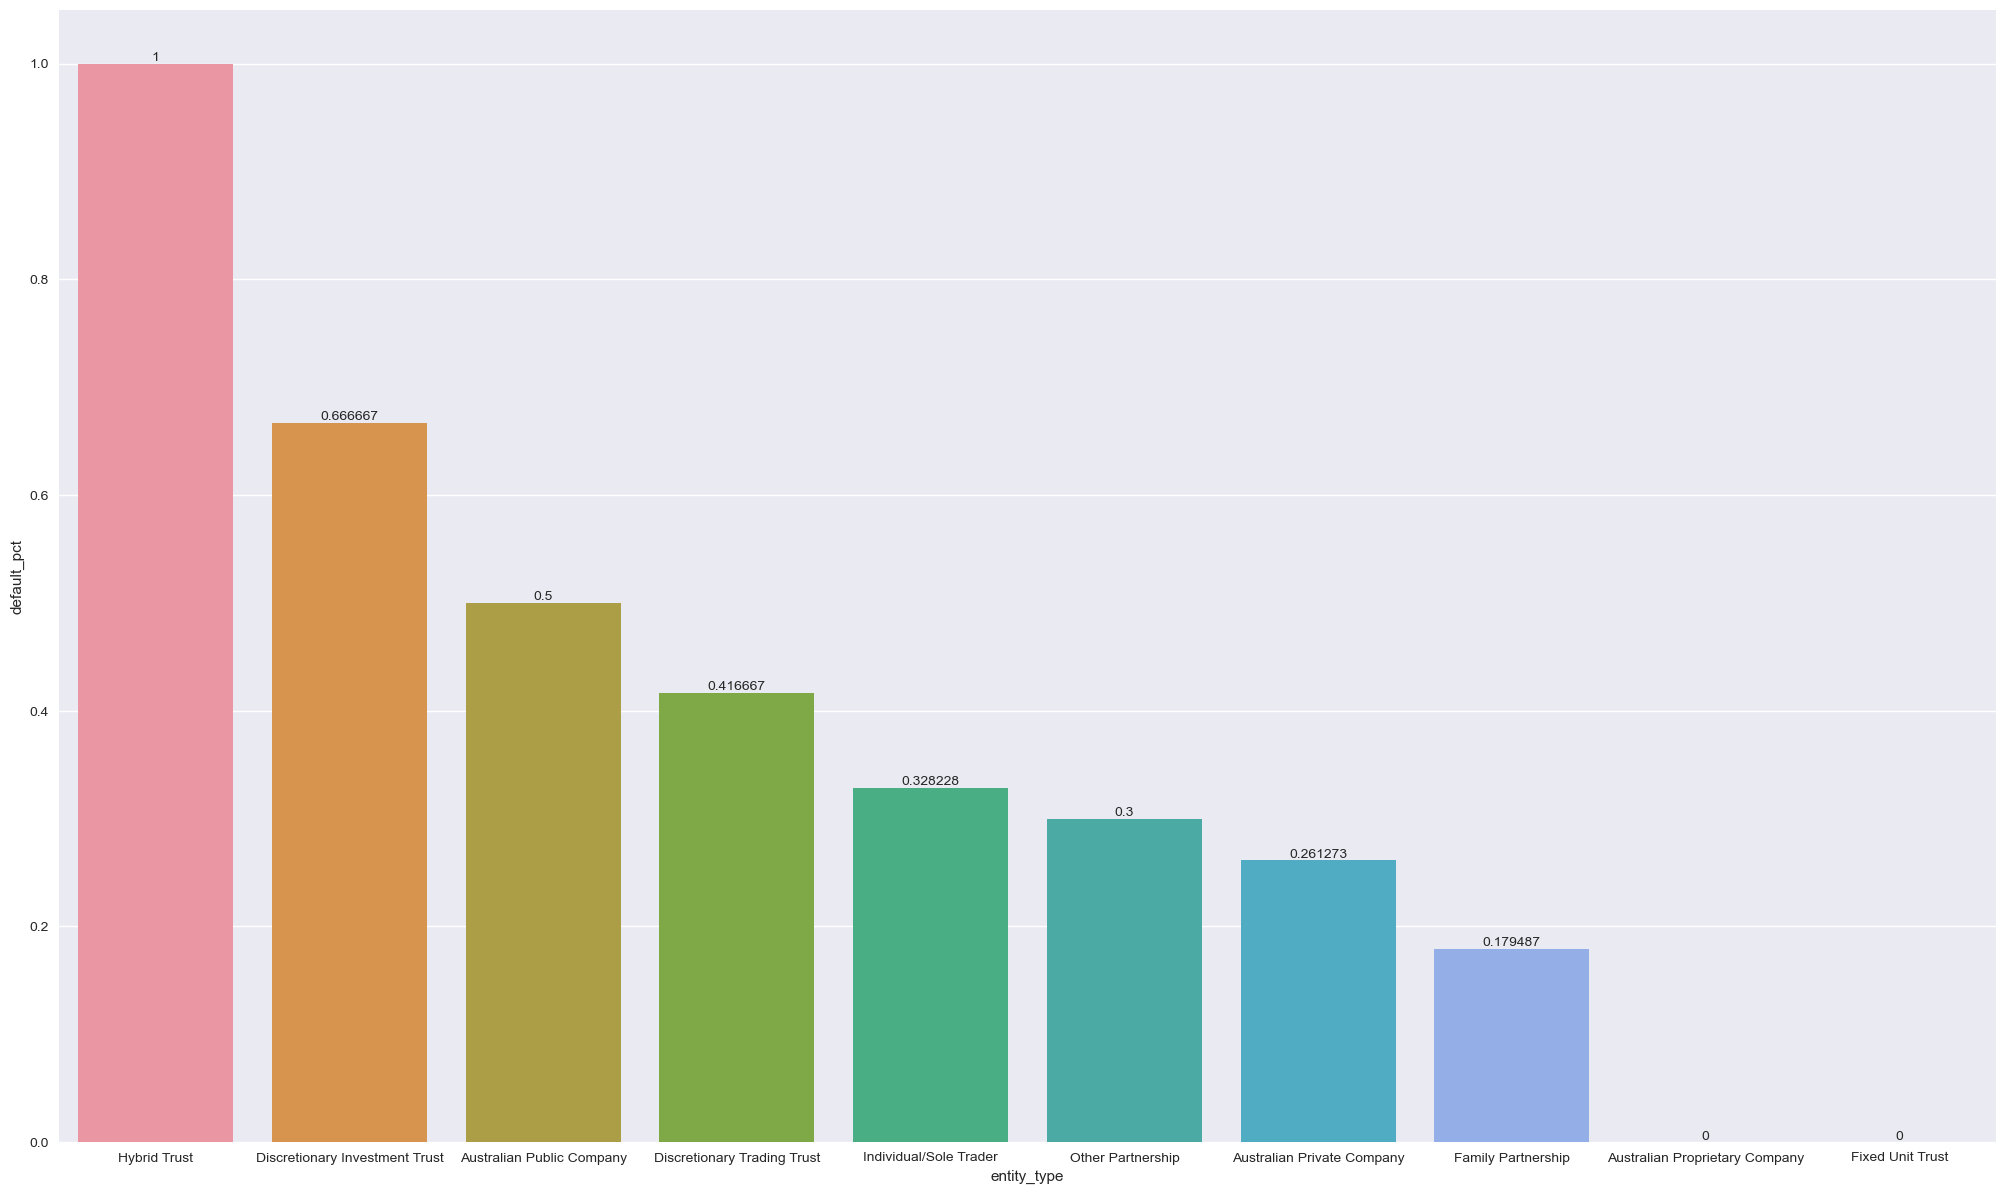

In [45]:
entity_default_rate = default_status.groupby("entity_type").payment_code.mean().reset_index(name="default_pct")
entity_default_rate["default_pct"] = 1 - entity_default_rate["default_pct"]
entity_default_rate = entity_default_rate.sort_values(by="default_pct", ascending=False)
entity_default_rate
plt.figure(figsize=(25,15))
ax = sns.barplot(data=entity_default_rate, x="entity_type", y="default_pct", order=entity_default_rate['entity_type'])
ax.bar_label(ax.containers[0])
plt.show()

##### Code

In [46]:
entity_default = default_status[default_status.payment_code == False].groupby("entity_type").size().reset_index(name='default')
entity_default

entity_type  default
0      Australian Private Company      197
1       Australian Public Company        3
2  Discretionary Investment Trust        2
3     Discretionary Trading Trust        5
4              Family Partnership        7
5                    Hybrid Trust        1
6          Individual/Sole Trader      150
7               Other Partnership        3

In [47]:
entity_total = default_status.groupby("entity_type").size().reset_index(name='total')
# entity_total["default_company_pct"] = entity_default["default"] / entity_total["total"] 
entity_total 

entity_type  total
0      Australian Private Company    754
1  Australian Proprietary Company      1
2       Australian Public Company      6
3  Discretionary Investment Trust      3
4     Discretionary Trading Trust     12
5              Family Partnership     39
6                Fixed Unit Trust      4
7                    Hybrid Trust      1
8          Individual/Sole Trader    457
9               Other Partnership     10

In [48]:
entity_total = pd.merge(entity_total, entity_default, on="entity_type", how="left").fillna(0)
entity_total

entity_type  total  default
0      Australian Private Company    754    197.0
1  Australian Proprietary Company      1      0.0
2       Australian Public Company      6      3.0
3  Discretionary Investment Trust      3      2.0
4     Discretionary Trading Trust     12      5.0
5              Family Partnership     39      7.0
6                Fixed Unit Trust      4      0.0
7                    Hybrid Trust      1      1.0
8          Individual/Sole Trader    457    150.0
9               Other Partnership     10      3.0

In [49]:
entity_default_rate.set_index("entity_type", inplace=True)

##### Results

In [50]:
entity_total

entity_type  total  default
0      Australian Private Company    754    197.0
1  Australian Proprietary Company      1      0.0
2       Australian Public Company      6      3.0
3  Discretionary Investment Trust      3      2.0
4     Discretionary Trading Trust     12      5.0
5              Family Partnership     39      7.0
6                Fixed Unit Trust      4      0.0
7                    Hybrid Trust      1      1.0
8          Individual/Sole Trader    457    150.0
9               Other Partnership     10      3.0

In [51]:
px.pie(entity_total, values="default", names=entity_total.entity_type)

This above shows the percentage of the types of companies that default
* Australian Private Companies and Sole Traders makes up most of the companies 

In [52]:
print("Number of companies that has defaulted: ", entity_total.default.sum())

Number of companies that has defaulted:  368.0


#### 2.2.2 Entity Default Amount Percentage

##### Code

In [53]:
entity_default_liability = entity.groupby(["client_id", "entity_type", "entity_year_established"]).payment_amt.sum().reset_index(name='liability')
entity_default_liability = entity_default_liability.loc[:, ["client_id", "liability"]]
entity_default_liability

client_id  liability
0             1    9016.68
1             2   25950.03
2             3    4261.68
3             4    8016.56
4             5    5211.69
...         ...        ...
1282       1277   21731.73
1283       1278    9999.98
1284       1279  108658.32
1285       1280   21731.73
1286       1281   20000.06

[1287 rows x 2 columns]

In [54]:
entity_default_count = default_count.loc[:, ["client_id", "entity_type", "default_count"]]
entity_default_count.head(10)

client_id                 entity_type  default_count
0          1           Other Partnership              0
1          2  Australian Private Company              0
2          3  Australian Private Company              0
3          4  Australian Private Company              0
4          5  Australian Private Company              0
5          6  Australian Private Company              0
6          7  Australian Private Company              4
7          8      Individual/Sole Trader              0
8          9      Individual/Sole Trader              0
9         10  Australian Private Company              0

In [55]:
entity_amount = pd.merge(entity_default_count, entity_default_liability, on="client_id")
entity_amount

client_id                  entity_type  default_count  liability
0             1            Other Partnership              0    9016.68
1             2   Australian Private Company              0   25950.03
2             3   Australian Private Company              0    4261.68
3             4   Australian Private Company              0    8016.56
4             5   Australian Private Company              0    5211.69
...         ...                          ...            ...        ...
1296       1277       Individual/Sole Trader              0   21731.73
1297       1278             Fixed Unit Trust              0    9999.98
1298       1279  Discretionary Trading Trust              0  108658.32
1299       1280   Australian Private Company              0   21731.73
1300       1281   Australian Private Company              0   20000.06

[1301 rows x 4 columns]

In [56]:
entity_default_amount = entity_amount[entity_amount.default_count > 0].groupby("entity_type").liability.sum().reset_index(name='default')
entity_default_amount

entity_type     default
0      Australian Private Company  7837580.09
1       Australian Public Company    56904.13
2  Discretionary Investment Trust   346732.93
3     Discretionary Trading Trust   164993.34
4              Family Partnership   129118.15
5                    Hybrid Trust    21374.96
6          Individual/Sole Trader  2394188.19
7               Other Partnership    16386.78

##### Results

In [57]:
px.pie(entity_default_amount, values="default", names=entity_default_amount.entity_type)

## 2.3 Default Rate by Year

<AxesSubplot:xlabel='entity_year_established', ylabel='default_pct'>

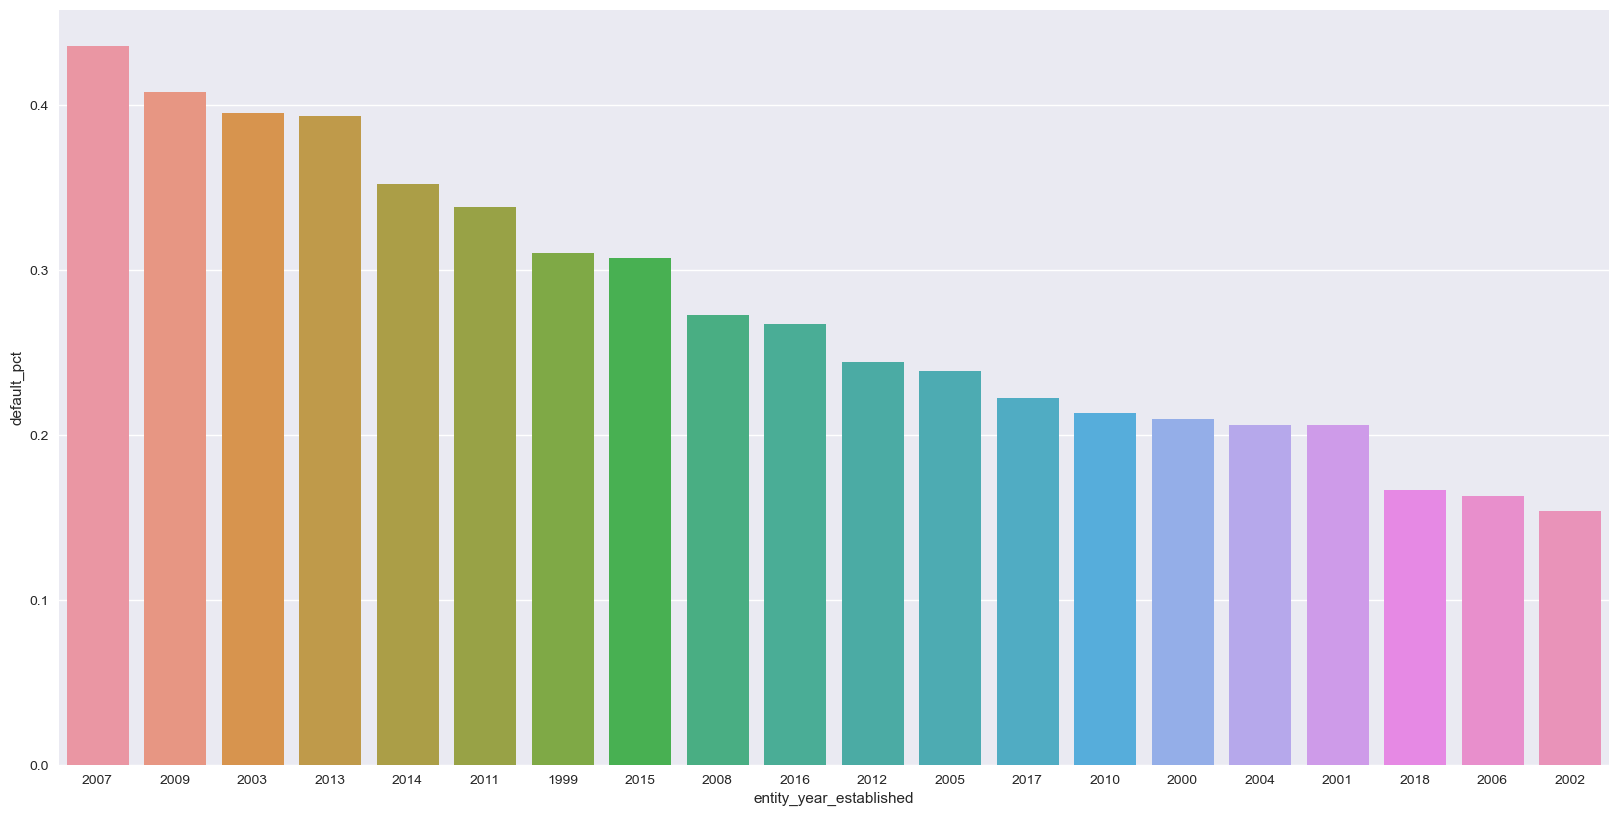

In [58]:
entity_default_rate = default_status.groupby("entity_year_established").payment_code.mean().reset_index(name="default_pct")
entity_default_rate["default_pct"] = 1 - entity_default_rate["default_pct"]
entity_default_rate = entity_default_rate.sort_values(by="default_pct", ascending=False)
entity_default_rate
sns.barplot(data=entity_default_rate, x="entity_year_established", y="default_pct", order=entity_default_rate['entity_year_established'])

In [59]:
year_default = default_status[default_status.payment_code == False].groupby("entity_year_established").size().reset_index(name='default')
year_default

entity_year_established  default
0                      1999        9
1                      2000       35
2                      2001        7
3                      2002        4
4                      2003       17
5                      2004        7
6                      2005       11
7                      2006        8
8                      2007       24
9                      2008       15
10                     2009       20
11                     2010       13
12                     2011       23
13                     2012       21
14                     2013       37
15                     2014       43
16                     2015       36
17                     2016       27
18                     2017       10
19                     2018        1

In [60]:
px.pie(year_default, values="default", names=year_default.entity_year_established)

##### Default Year that carries the most liability

In [61]:
entity_default_liability

client_id  liability
0             1    9016.68
1             2   25950.03
2             3    4261.68
3             4    8016.56
4             5    5211.69
...         ...        ...
1282       1277   21731.73
1283       1278    9999.98
1284       1279  108658.32
1285       1280   21731.73
1286       1281   20000.06

[1287 rows x 2 columns]

In [62]:
default_status

client_id                  entity_type  entity_year_established  \
0             1            Other Partnership                     2006   
1             2   Australian Private Company                     2001   
2             3   Australian Private Company                     2002   
3             4   Australian Private Company                     2007   
4             5   Australian Private Company                     2007   
...         ...                          ...                      ...   
1282       1277       Individual/Sole Trader                     2004   
1283       1278             Fixed Unit Trust                     2007   
1284       1279  Discretionary Trading Trust                     2017   
1285       1280   Australian Private Company                     2016   
1286       1281   Australian Private Company                     2012   

      payment_code  
0             True  
1             True  
2             True  
3             True  
4             True  
...            ...  
1282          True  
1283          True  
1284          True  
1285          True  
1286          True  

[1287 rows x 4 columns]

In [63]:
year_default_liability = pd.merge(default_status, entity_default_liability,on="client_id")
year_default_liability = year_default_liability[year_default_liability.payment_code == False]
year_default_liability = year_default_liability.groupby("entity_year_established").liability.sum().reset_index()
year_default_liability.sort_values(by="liability", ascending=False)

entity_year_established   liability
16                     2015  1380107.51
14                     2013  1166675.99
1                      2000  1138515.90
15                     2014  1109600.54
8                      2007  1021937.81
13                     2012   719005.48
17                     2016   621876.58
12                     2011   593609.50
4                      2003   496402.89
11                     2010   473900.12
10                     2009   442915.09
7                      2006   312230.48
9                      2008   273345.66
5                      2004   264984.11
0                      1999   253013.36
6                      2005   214708.37
18                     2017   203079.22
2                      2001   166084.58
3                      2002   107134.42
19                     2018     8150.96

In [64]:
px.pie(year_default_liability, values="liability", names=year_default_liability.entity_year_established)

In [65]:
group_year_default = pd.merge(year_default, year_default_liability, on="entity_year_established")
group_year_default

entity_year_established  default   liability
0                      1999        9   253013.36
1                      2000       35  1138515.90
2                      2001        7   166084.58
3                      2002        4   107134.42
4                      2003       17   496402.89
5                      2004        7   264984.11
6                      2005       11   214708.37
7                      2006        8   312230.48
8                      2007       24  1021937.81
9                      2008       15   273345.66
10                     2009       20   442915.09
11                     2010       13   473900.12
12                     2011       23   593609.50
13                     2012       21   719005.48
14                     2013       37  1166675.99
15                     2014       43  1109600.54
16                     2015       36  1380107.51
17                     2016       27   621876.58
18                     2017       10   203079.22
19                     2018        1     8150.96

# 3. Feature Engineering

##### Number of Companies Owned by A Client (df: client_company_info)

In [66]:
default_status.iloc[:, :2]

client_id                  entity_type
0             1            Other Partnership
1             2   Australian Private Company
2             3   Australian Private Company
3             4   Australian Private Company
4             5   Australian Private Company
...         ...                          ...
1282       1277       Individual/Sole Trader
1283       1278             Fixed Unit Trust
1284       1279  Discretionary Trading Trust
1285       1280   Australian Private Company
1286       1281   Australian Private Company

[1287 rows x 2 columns]

In [67]:
client_company_info = default_status.iloc[:, :2].pivot_table(index=['client_id'], aggfunc=[len], columns=['entity_type'], fill_value=0)
client_company_info.columns = client_company_info.columns.droplevel(0) #remove amount
client_company_info.columns.name = None               #remove categories
client_company_info = client_company_info.reset_index()
client_company_info

client_id  Australian Private Company  Australian Proprietary Company  \
0             1                           0                               0   
1             2                           1                               0   
2             3                           1                               0   
3             4                           1                               0   
4             5                           1                               0   
...         ...                         ...                             ...   
1276       1277                           0                               0   
1277       1278                           0                               0   
1278       1279                           0                               0   
1279       1280                           1                               0   
1280       1281                           1                               0   

      Australian Public Company  Discretionary Investment Trust  \
0                             0                               0   
1                             0                               0   
2                             0                               0   
3                             0                               0   
4                             0                               0   
...                         ...                             ...   
1276                          0                               0   
1277                          0                               0   
1278                          0                               0   
1279                          0                               0   
1280                          0                               0   

      Discretionary Trading Trust  Family Partnership  Fixed Unit Trust  \
0                               0                   0                 0   
1                               0                   0                 0   
2                               0                   0                 0   
3                               0                   0                 0   
4                               0                   0                 0   
...                           ...                 ...               ...   
1276                            0                   0                 0   
1277                            0                   0                 1   
1278                            1                   0                 0   
1279                            0                   0                 0   
1280                            0                   0                 0   

      Hybrid Trust  Individual/Sole Trader  Other Partnership  
0                0                       0                  1  
1                0                       0                  0  
2                0                       0                  0  
3                0                       0                  0  
4                0                       0                  0  
...            ...                     ...                ...  
1276             0                       1                  0  
1277             0                       0                  0  
1278             0                       0                  0  
1279             0                       0                  0  
1280             0                       0                  0  

[1281 rows x 11 columns]

##### Number of Contracts by a Client (df: n_contracts)

In [68]:
n_contracts = df.groupby(["client_id"]).contract_id.nunique().reset_index()
n_contracts

client_id  contract_id
0             1            1
1             2            1
2             3            2
3             4            1
4             5            1
...         ...          ...
1276       1277            1
1277       1278            1
1278       1279            1
1279       1280            1
1280       1281            1

[1281 rows x 2 columns]

##### Average Transaction/Payment Interval (df: avg_txn_interval)

In [69]:
transaction = df.groupby(["client_id", "transaction_date"]).payment_amt.mean().reset_index()
transaction

client_id transaction_date  payment_amt
0              1       2017-11-22     2550.020
1              1       2017-11-26      266.665
2              1       2017-12-21      241.665
3              1       2018-02-22      241.665
4              1       2018-03-22      241.665
...          ...              ...          ...
12971       1279       2018-07-17    49999.990
12972       1279       2018-07-22     4329.170
12973       1280       2018-07-16    10000.030
12974       1280       2018-07-19      865.835
12975       1281       2018-07-22    10000.030

[12976 rows x 3 columns]

In [70]:
# avg_txn_interval = df[df.client_id == 1278].sort_values(by="transaction_date")
# avg_txn_interval = df.groupby(["client_id", "transaction_date"]).payment_amt.sum().reset_index()
# avg_txn_interval

In [71]:
avg_txn_interval = df.groupby(["client_id", "transaction_date"]).payment_amt.sum().reset_index()
avg_txn_interval['previous_schedule'] = avg_txn_interval.groupby(['client_id'])['transaction_date'].shift()
avg_txn_interval['next_schedule'] = avg_txn_interval['transaction_date'] - avg_txn_interval['previous_schedule']
avg_txn_interval['next_schedule'] = avg_txn_interval['next_schedule'].apply(lambda x: x.days)
avg_txn_interval = avg_txn_interval.groupby('client_id')['next_schedule'].agg('mean').reset_index().fillna(0)
avg_txn_interval.rename(columns={"next_schedule" : "avg_txn_interval"}, inplace=True)
avg_txn_interval

client_id  avg_txn_interval
0             1         30.250000
1             2         21.000000
2             3         39.222222
3             4         27.300000
4             5         25.000000
...         ...               ...
1276       1277          3.000000
1277       1278          0.000000
1278       1279          5.000000
1279       1280          3.000000
1280       1281          0.000000

[1281 rows x 2 columns]

##### Effects of Payment Intervals for Clients Analysis

In [72]:
avg_txn_interval_default = pd.merge(avg_txn_interval, default_status_list, on="client_id")
avg_txn_interval_default

client_id  avg_txn_interval  payment_code
0             1         30.250000          True
1             2         21.000000          True
2             3         39.222222          True
3             4         27.300000          True
4             5         25.000000          True
...         ...               ...           ...
1282       1277          3.000000          True
1283       1278          0.000000          True
1284       1279          5.000000          True
1285       1280          3.000000          True
1286       1281          0.000000          True

[1287 rows x 3 columns]

In [73]:
avg_txn_interval_default_clean = removeOutlier(avg_txn_interval_default, "avg_txn_interval")


([<matplotlib.axis.XTick at 0x28834625700>,
 [Text(0, 0, 'Default'), Text(1, 0, 'Payment')])

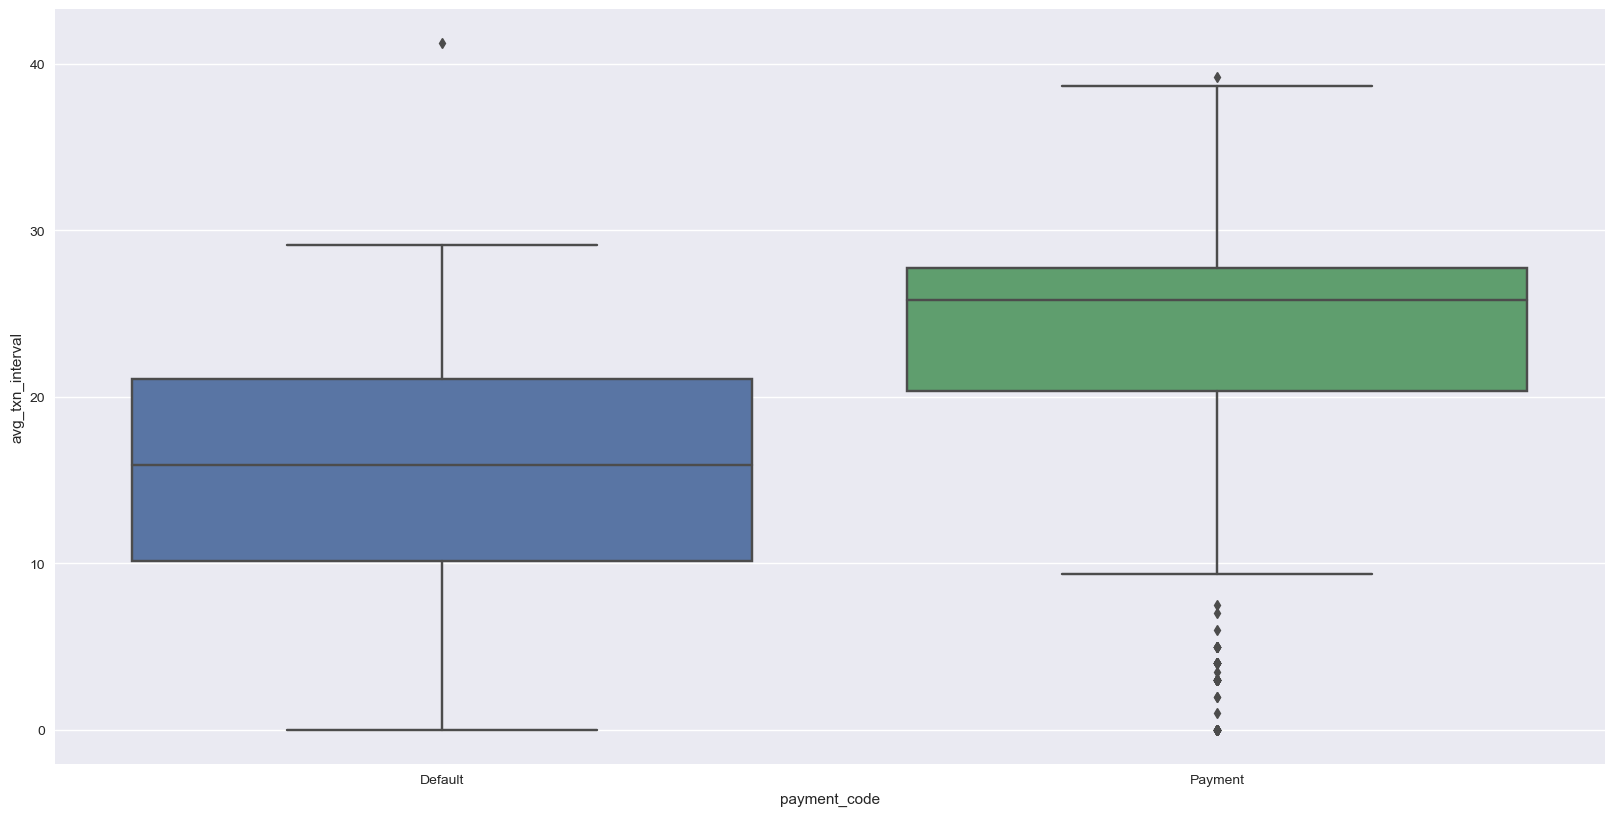

In [74]:
sns.boxplot(x="payment_code", y="avg_txn_interval", data=avg_txn_interval_default_clean)
plt.xticks([0, 1], ["Default", "Payment"])

In [75]:
avg_txn_interval_default_clean[avg_txn_interval_default_clean.payment_code == True].describe()


client_id  avg_txn_interval
count   917.000000        917.000000
mean    653.988004         22.447979
std     380.355552          8.851433
min       1.000000          0.000000
25%     317.000000         20.333333
50%     651.000000         25.846154
75%     991.000000         27.727273
max    1281.000000         39.222222

In [76]:
avg_txn_interval_default_clean[avg_txn_interval_default_clean.payment_code == False].describe()


client_id  avg_txn_interval
count   362.000000        362.000000
mean    605.690608         15.743822
std     342.583315          6.634970
min       7.000000          0.000000
25%     328.500000         10.167857
50%     594.000000         15.916667
75%     887.250000         21.071581
max    1254.000000         41.222222

The intervals of payment may have some effects on the default probability of a client

### Final Merged DataFrame

total_liability is also a feature we want

In [77]:
df_default = pd.merge(avg_txn_interval, client_company_info, on="client_id")

In [78]:
df_default = pd.merge(df_default, n_contracts, on="client_id")
df_default = pd.merge(df_default, clients[["client_id", "entity_year_established"]], on="client_id")
df_default = pd.merge(df_default, total_liability, on="client_id")

df_default

client_id  avg_txn_interval  Australian Private Company  \
0             1         30.250000                           0   
1             2         21.000000                           1   
2             3         39.222222                           1   
3             4         27.300000                           1   
4             5         25.000000                           1   
...         ...               ...                         ...   
1282       1277          3.000000                           0   
1283       1278          0.000000                           0   
1284       1279          5.000000                           0   
1285       1280          3.000000                           1   
1286       1281          0.000000                           1   

      Australian Proprietary Company  Australian Public Company  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   
3                                  0                          0   
4                                  0                          0   
...                              ...                        ...   
1282                               0                          0   
1283                               0                          0   
1284                               0                          0   
1285                               0                          0   
1286                               0                          0   

      Discretionary Investment Trust  Discretionary Trading Trust  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...                          ...   
1282                               0                            0   
1283                               0                            0   
1284                               0                            1   
1285                               0                            0   
1286                               0                            0   

      Family Partnership  Fixed Unit Trust  Hybrid Trust  \
0                      0                 0             0   
1                      0                 0             0   
2                      0                 0             0   
3                      0                 0             0   
4                      0                 0             0   
...                  ...               ...           ...   
1282                   0                 0             0   
1283                   0                 1             0   
1284                   0                 0             0   
1285                   0                 0             0   
1286                   0                 0             0   

      Individual/Sole Trader  Other Partnership  contract_id  \
0                          0                  1            1   
1                          0                  0            1   
2                          0                  0            2   
3                          0                  0            1   
4                          0                  0            1   
...                      ...                ...          ...   
1282                       1                  0            1   
1283                       0                  0            1   
1284                       0                  0            1   
1285                       0                  0            1   
1286                       0                  0            1   

      entity_year_established  payment_amt  payment_code  
0                        2006      9016.68

# 4. Modeling

In [107]:
from sklearn          import tree
from xgboost          import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree     import DecisionTreeClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics         import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

In [79]:
X = df_default.iloc[:, 1:-1]
y = df_default.iloc[:, -1].map({True:0, False:1})

In [80]:
X

avg_txn_interval  Australian Private Company  \
0            30.250000                           0   
1            21.000000                           1   
2            39.222222                           1   
3            27.300000                           1   
4            25.000000                           1   
...                ...                         ...   
1282          3.000000                           0   
1283          0.000000                           0   
1284          5.000000                           0   
1285          3.000000                           1   
1286          0.000000                           1   

      Australian Proprietary Company  Australian Public Company  \
0                                  0                          0   
1                                  0                          0   
2                                  0                          0   
3                                  0                          0   
4                                  0                          0   
...                              ...                        ...   
1282                               0                          0   
1283                               0                          0   
1284                               0                          0   
1285                               0                          0   
1286                               0                          0   

      Discretionary Investment Trust  Discretionary Trading Trust  \
0                                  0                            0   
1                                  0                            0   
2                                  0                            0   
3                                  0                            0   
4                                  0                            0   
...                              ...                          ...   
1282                               0                            0   
1283                               0                            0   
1284                               0                            1   
1285                               0                            0   
1286                               0                            0   

      Family Partnership  Fixed Unit Trust  Hybrid Trust  \
0                      0                 0             0   
1                      0                 0             0   
2                      0                 0             0   
3                      0                 0             0   
4                      0                 0             0   
...                  ...               ...           ...   
1282                   0                 0             0   
1283                   0                 1             0   
1284                   0                 0             0   
1285                   0                 0             0   
1286                   0                 0             0   

      Individual/Sole Trader  Other Partnership  contract_id  \
0                          0                  1            1   
1                          0                  0            1   
2                          0                  0            2   
3                          0                  0            1   
4                          0                  0            1   
...                      ...                ...          ...   
1282                       1                  0            1   
1283                       0                  0            1   
1284                       0                  0            1   
1285                       0                  0            1   
1286                       0                  0            1   

      entity_year_established  payment_amt  
0                        2006      9016.68  
1                        2001     25950.03  
2                        2002      4261.68  
3                        2007      8016.56  
4       

In [81]:
y

0       0
1       0
2       0
3       0
4       0
       ..
1282    0
1283    0
1284    0
1285    0
1286    0
Name: payment_code, Length: 1287, dtype: int64

In [159]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, stratify=y)

### DTree

In [136]:
tree_params = {
    'max_leaf_nodes': np.arange(1, 10), 
    'min_samples_split': [2, 3, 4],
    'max_depth': [2,3,4],
    'criterion':['gini','entropy'],
    'max_features': np.arange(1,11)
}

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

tree_clf = DecisionTreeClassifier()

tree_random_search = RandomizedSearchCV(tree_clf, param_distributions=tree_params, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=skf.split(X, y), verbose=0, random_state=0)

tree_random_search.fit(X, y)


d:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning:


10 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "d:\Anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 314, in fit
    raise ValueError(
ValueError: max_leaf_nodes 1 must be either None or larger than 1


d:\Anaconda3\lib\site-packages\sklearn\model_selection\_sea

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000028837943A50>,
                   estimator=DecisionTreeClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 4],
                                        'max_features': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'max_leaf_nodes': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                                        'min_samples_split': [2, 3, 4]},
                   random_state=0, scoring='roc_auc')

In [111]:
tree_random_search.best_estimator_.feature_importances_

array([0.97657248, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.02342752, 0.        , 0.        ])

In [154]:
score = cross_val_score(tree_random_search.best_estimator_, X, y, cv=skf, verbose=0)
score.mean()

0.8329412119566856

In [116]:
[(feature, importance) for feature, importance, in zip(X.columns, tree_random_search.best_estimator_.feature_importances_)]

[('avg_txn_interval', 0.9765724816495858),
 ('Australian Private Company', 0.0),
 ('Australian Proprietary Company', 0.0),
 ('Australian Public Company', 0.0),
 ('Discretionary Investment Trust', 0.0),
 ('Discretionary Trading Trust', 0.0),
 ('Family Partnership', 0.0),
 ('Fixed Unit Trust', 0.0),
 ('Hybrid Trust', 0.0),
 ('Individual/Sole Trader', 0.0),
 ('Other Partnership', 0.0),
 ('contract_id', 0.023427518350414185),
 ('entity_year_established', 0.0),
 ('payment_amt', 0.0)]

Precision and Recall

In [155]:
tree_random_search.best_estimator_.fit(X_train, y_train)

y_pred = tree_random_search.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

              precision    recall  f1-score   support

     PAYMENT       0.90      0.67      0.77       230
     DEFAULT       0.50      0.80      0.61        92

    accuracy                           0.71       322
   macro avg       0.70      0.74      0.69       322
weighted avg       0.78      0.71      0.72       322



In [169]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

nested_score = cross_val_score(tree_random_search.best_estimator_, X, y, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score.mean() )

              precision    recall  f1-score   support

           0       0.73      0.99      0.84       184
           1       0.75      0.08      0.15        74

    accuracy                           0.73       258
   macro avg       0.74      0.54      0.49       258
weighted avg       0.73      0.73      0.64       258

              precision    recall  f1-score   support

           0       0.86      0.79      0.82       184
           1       0.56      0.68      0.61        74

    accuracy                           0.76       258
   macro avg       0.71      0.73      0.72       258
weighted avg       0.77      0.76      0.76       258

              precision    recall  f1-score   support

           0       0.88      0.92      0.90       184
           1       0.77      0.67      0.72        73

    accuracy                           0.85       257
   macro avg       0.82      0.79      0.81       257
weighted avg       0.84      0.85      0.85       257

              preci

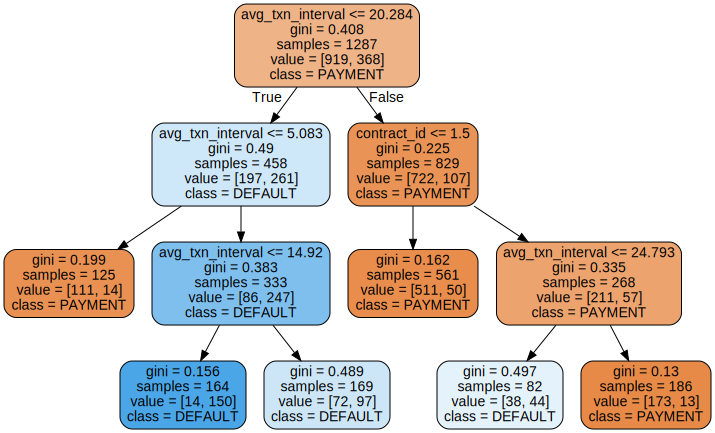

In [112]:
import graphviz
data = tree.export_graphviz(
    tree_random_search.best_estimator_,
    feature_names=X.columns,
    class_names=["PAYMENT", "DEFAULT"],
    rounded=True,
    filled=True
)
graphviz.Source(data)

### Random Forest

In [90]:
param_grid = { 
    'n_estimators': [1000, 3000, 5000, 7000, 10000, 20000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : np.arange(2,8),
    'criterion' :['gini', 'entropy']
}

In [93]:
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)

In [94]:
rfc = RandomForestClassifier()

In [95]:
# rfcSearch = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= skf, n_jobs=-1)
rfc_random_search = RandomizedSearchCV(rfc, param_distributions=param_grid, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=skf.split(X, y), verbose=0, random_state=0)

In [96]:
rfc_random_search.fit(X,y)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x0000028837832270>,
                   estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': array([2, 3, 4, 5, 6, 7]),
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [1000, 3000, 5000, 7000,
                                                         10000, 20000]},
                   random_state=0, scoring='roc_auc')

Param Search Results

In [97]:
rfc_random_search.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=7, max_features='sqrt',
                       n_estimators=1000)

In [98]:
rfc_random_search.best_params_

{'n_estimators': 1000,
 'max_features': 'sqrt',
 'max_depth': 7,
 'criterion': 'entropy'}

##### StratifiedKFold Cross Val Score

In [99]:
score = cross_val_score(rfc_random_search.best_estimator_, X, y, cv=skf, verbose=0)

In [100]:
score.mean()

0.8430488945193495

##### Feature Importance Ranking

In [170]:
[(feature, importance) for feature, importance, in zip(X.columns, rfc_random_search.best_estimator_.feature_importances_)]

[('avg_txn_interval', 0.6301038996384607),
 ('Australian Private Company', 0.021381760848361183),
 ('Australian Proprietary Company', 0.0007125657726245822),
 ('Australian Public Company', 0.004739445587758439),
 ('Discretionary Investment Trust', 0.005103743454545475),
 ('Discretionary Trading Trust', 0.0047806563617322235),
 ('Family Partnership', 0.009559728758824415),
 ('Fixed Unit Trust', 0.0022278244496673635),
 ('Hybrid Trust', 0.005742787452874119),
 ('Individual/Sole Trader', 0.015405260944440436),
 ('Other Partnership', 0.0030266120176641507),
 ('contract_id', 0.05100769344264226),
 ('entity_year_established', 0.0882594040926264),
 ('payment_amt', 0.15794861717777822)]

##### Precision and Recall

In [160]:
rfc_random_search.best_estimator_.fit(X_train, y_train)

y_pred = rfc_random_search.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

              precision    recall  f1-score   support

     PAYMENT       0.85      0.96      0.90       230
     DEFAULT       0.84      0.59      0.69        92

    accuracy                           0.85       322
   macro avg       0.85      0.77      0.80       322
weighted avg       0.85      0.85      0.84       322



In [167]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

nested_score = cross_val_score(rfc_random_search.best_estimator_, X, y, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score.mean() )

              precision    recall  f1-score   support

           0       0.84      0.96      0.89       184
           1       0.83      0.54      0.66        74

    accuracy                           0.84       258
   macro avg       0.84      0.75      0.77       258
weighted avg       0.84      0.84      0.83       258

              precision    recall  f1-score   support

           0       0.85      0.95      0.90       184
           1       0.83      0.58      0.68        74

    accuracy                           0.84       258
   macro avg       0.84      0.77      0.79       258
weighted avg       0.84      0.84      0.84       258

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       184
           1       0.82      0.62      0.70        73

    accuracy                           0.85       257
   macro avg       0.84      0.78      0.80       257
weighted avg       0.85      0.85      0.85       257

              preci

### XGBoost

In [172]:
params = {
    'max_depth':        [3, 4, 5, 6, 7],
    'min_child_weight': np.arange(1, 11),
    'subsample':        [0.6, 0.8, 1.0],
    'colsample_bytree': np.arange(0.01, 0.11, 0.01),
    'gamma':            [0.5, 1, 1.5, 2, 3, 4, 5],
    'n_estimators':     [1000, 3000, 5000, 7000, 10000, 20000],
    'learning_rate':    np.arange(0.01, 0.1, 0.02)
}

xgb = XGBClassifier(nthread=8, 
                    use_label_encoder=False,
                    eval_metric='logloss')

skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)
random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=20, scoring='roc_auc', n_jobs=-1, cv=skf.split(X, y), verbose=0, random_state=0)

In [173]:
random_search.fit(X, y)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000288379B2270>,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False,
                                           eval_metric='logloss', gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=...
                   param_distributions={'colsample_bytree': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ]),
                                        'gamma': [0.5, 1, 1.5, 2, 3, 4, 5],
                  

In [125]:
random_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.03,
              enable_categorical=False, eval_metric='logloss', gamma=3,
              gpu_id=-1, importance_type=None, interaction_constraints='',
              learning_rate=0.03, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=20000, n_jobs=8, nthread=8, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1.0, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, ...)

In [129]:
random_search.best_params_

{'subsample': 1.0,
 'n_estimators': 20000,
 'min_child_weight': 1,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 3,
 'colsample_bytree': 0.03}

##### StratifiedKFold Cross Val Score

In [174]:
score = cross_val_score(random_search.best_estimator_, X, y, cv=skf, verbose=0)
score.mean()

0.8881307875607034

##### Feature Importance Ranking

In [175]:
[(feature, importance) for feature, importance, in zip(X.columns, random_search.best_estimator_.feature_importances_)]

[('avg_txn_interval', 0.45640707),
 ('Australian Private Company', 0.115753174),
 ('Australian Proprietary Company', 0.0),
 ('Australian Public Company', 0.0),
 ('Discretionary Investment Trust', 0.0),
 ('Discretionary Trading Trust', 0.0),
 ('Family Partnership', 0.0),
 ('Fixed Unit Trust', 0.0),
 ('Hybrid Trust', 0.0),
 ('Individual/Sole Trader', 0.11852461),
 ('Other Partnership', 0.0),
 ('contract_id', 0.09831766),
 ('entity_year_established', 0.11096874),
 ('payment_amt', 0.1000287)]

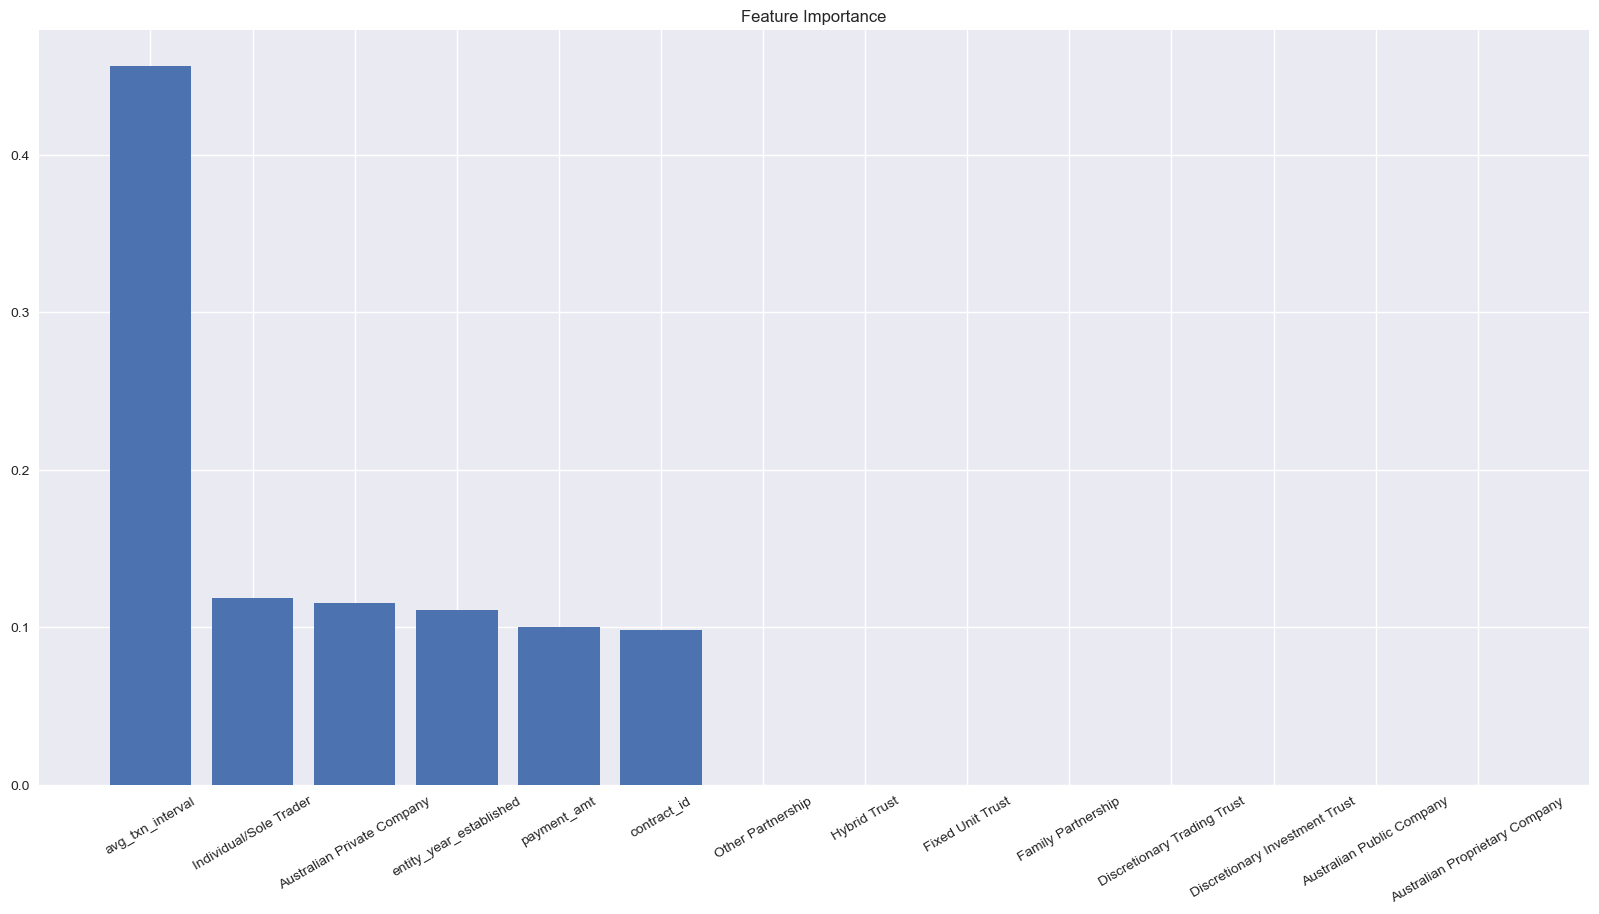

In [182]:
# Calculate feature importances
importances = random_search.best_estimator_.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(importances)[::-1]

names = [X.columns[i] for i in indices]

# Create plot
plt.figure()
# Create plot title
plt.title("Feature Importance")
# Add bars
plt.bar(range(X.shape[1]), importances[indices])
# Add feature names as x-axis labels
plt.xticks(range(X.shape[1]), names, rotation=30)
# Show plot
plt.show()

##### Precision and Recall

In [161]:
random_search.best_estimator_.fit(X_train, y_train)

y_pred = random_search.best_estimator_.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

     PAYMENT       0.87      0.94      0.90       230
     DEFAULT       0.82      0.64      0.72        92

    accuracy                           0.86       322
   macro avg       0.84      0.79      0.81       322
weighted avg       0.85      0.86      0.85       322



In [166]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

nested_score = cross_val_score(random_search.best_estimator_, X, y, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score.mean() )

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       184
           1       0.88      0.70      0.78        74

    accuracy                           0.89       258
   macro avg       0.89      0.83      0.85       258
weighted avg       0.89      0.89      0.88       258

              precision    recall  f1-score   support

           0       0.88      0.93      0.91       184
           1       0.81      0.69      0.74        74

    accuracy                           0.86       258
   macro avg       0.85      0.81      0.83       258
weighted avg       0.86      0.86      0.86       258

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       184
           1       0.91      0.79      0.85        73

    accuracy                           0.92       257
   macro avg       0.91      0.88      0.90       257
weighted avg       0.92      0.92      0.92       257

              preci

In [ ]:
import xgboost
from sklearn.utils.class_weight import compute_sample_weight
sample_weights = compute_sample_weight(
    class_weight='balanced',
    y=y_train
)
# xgb_clf = xgboost.XGBClassifier(learning_rate=0.02, 
#                                 n_estimators=10000,
#                                 nthread=8, 
#                                 use_label_encoder=False,
#                                 eval_metric='logloss',
#                                 subsample=1,
#                                 min_child_weight=5,
#                                 max_depth=4,
#                                 gamma=2,
#                                 colsample_bytree=0.8
#                             )
xgb_clf = random_search.best_estimator_

xgb_clf.fit(X_train, y_train, sample_weight=sample_weights)

y_pred = xgb_clf.predict(X_test)

In [ ]:
xgb_clf.score(X_test, y_test)

0.9006211180124224

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["PAYMENT", "DEFAULT"]))

              precision    recall  f1-score   support

     PAYMENT       0.93      0.93      0.93       229
     DEFAULT       0.82      0.84      0.83        93

    accuracy                           0.90       322
   macro avg       0.88      0.88      0.88       322
weighted avg       0.90      0.90      0.90       322



In [ ]:
skf   = StratifiedKFold(n_splits=5, shuffle = True, random_state = 0)
score = cross_val_score(xgb_clf, X, y, cv=skf, verbose=0)

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index wi

In [ ]:
score.mean()

0.8950954664736223

In [162]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

def classification_report_with_accuracy_score(y_true, y_pred):
    print (classification_report(y_true, y_pred)) # print classification report
    return accuracy_score(y_true, y_pred) # return accuracy score

nested_score = cross_val_score(xgb_clf, X, y, cv=skf, verbose=0,
               scoring=make_scorer(classification_report_with_accuracy_score))
print( nested_score )

d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

           0       0.91      0.96      0.93       184
           1       0.88      0.77      0.82        74

    accuracy                           0.90       258
   macro avg       0.89      0.86      0.88       258
weighted avg       0.90      0.90      0.90       258



d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

           0       0.92      0.95      0.93       184
           1       0.85      0.78      0.82        74

    accuracy                           0.90       258
   macro avg       0.88      0.86      0.87       258
weighted avg       0.90      0.90      0.90       258



d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

           0       0.90      0.93      0.91       184
           1       0.81      0.74      0.77        73

    accuracy                           0.88       257
   macro avg       0.85      0.83      0.84       257
weighted avg       0.87      0.88      0.87       257



d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

           0       0.92      0.95      0.93       184
           1       0.86      0.78      0.82        73

    accuracy                           0.90       257
   macro avg       0.89      0.87      0.88       257
weighted avg       0.90      0.90      0.90       257



d:\Anaconda3\lib\site-packages\xgboost\data.py:262: FutureWarning:

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.



              precision    recall  f1-score   support

           0       0.92      0.93      0.93       183
           1       0.83      0.80      0.81        74

    accuracy                           0.89       257
   macro avg       0.88      0.87      0.87       257
weighted avg       0.89      0.89      0.89       257

[0.90310078 0.89922481 0.87548638 0.90272374 0.89494163]


In [ ]:
[(feature, importance) for feature, importance, in zip(X.columns, xgb_clf.feature_importances_)]

[('avg_txn_interval', 0.23621392),
 ('Australian Private Company', 0.08947427),
 ('Australian Proprietary Company', 0.0),
 ('Australian Public Company', 0.0),
 ('Discretionary Investment Trust', 0.0),
 ('Discretionary Trading Trust', 0.0),
 ('Family Partnership', 0.07568262),
 ('Fixed Unit Trust', 0.0),
 ('Hybrid Trust', 0.0),
 ('Individual/Sole Trader', 0.09975731),
 ('Other Partnership', 0.14017276),
 ('contract_id', 0.1739495),
 ('entity_year_established', 0.0853047),
 ('payment_amt', 0.099444985)]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, target_names=["DEFAULT", "PAYMENT"]))


              precision    recall  f1-score   support

     DEFAULT       0.73      0.30      0.43       229
     PAYMENT       0.30      0.72      0.42        93

    accuracy                           0.42       322
   macro avg       0.51      0.51      0.42       322
weighted avg       0.60      0.42      0.42       322

